### Table of Contents in this notebook 

* [Analysis. 방문 고객의 클릭 수(행동 데이터)가 떨어지지 않게 할 수 없을까?](#chapter1)
    * [데이터 전처리](#section_1_0)
    * [이탈 고객 정의](#section_1_1)
    * [Cohort](#section_1_2)
    * [RFM Segment](#section_1_3)
    * [이탈 고객이 매출에 미치는 영향](#section_1_4)
    * [회귀분석](#section_1_5)
    * [고객 행동 분석](#section_1_6)
    * [이탈 고객 예측](#section_1_7)
    * [고객 군집](#section_1_8)
    * [장바구니 분석](#section_1_9)

- 배경: 해외 이커머스 기업이 국내에 진입하여 경쟁이 심화되고, 고객 충성도가 감소하고 있다. 고객 이탈은 기업의 수익에 큰 영향을 미치며, 기존 고객을 유지하는 것이 신규 고객을 유치하는 것보다 비용 효율적이다.
- 문제: 기존 고객 이탈 예측 모델의 해석 가능성이 낮다
- 목표:
    1. 고객 이탈 데이터를 기반으로 정확한 예측 모델 구축
    2. 모델 결과를 해석 가능하게 만들어, 기업이 효과적인 고객 유지 전략을 수립할 수 있도록 지원

#### 데이터 전처리 <a class="anchor" id="section_1_0"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
from datetime import datetime
pd.set_option('display.max_columns', None)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import set_config
import scipy.stats as stats
from operator import attrgetter
import matplotlib.colors as mcolors
# set_config(transform_output='pandas')

sns.set_style('whitegrid')
palette = 'Set2'
%matplotlib inline

In [ ]:
# 작업 디렉토리 설정
os.chdir('project/final/e-commerce/EDA/dataset/raw_data')

customer_raw = pd.read_csv('customer.csv')
product_raw = pd.read_csv('product.csv')
transactions_raw = pd.read_csv('transactions.csv')
click_stream_raw = pd.read_csv('click_stream.csv')

In [ ]:
# raw_data 전처리

def click_stream_preprocessing(click_stream_raw):
    # copy()
    click_stream_df = click_stream_raw.copy()
    
    # 날짜
    click_stream_df['event_date'] = click_stream_df['event_time'].str.split('T').str[0] # 년-월-일
    click_stream_df['event_hms'] = click_stream_df['event_time'].apply(lambda x : x.split('T')[1].split('.')[0]) # 시간-분-초
    click_stream_df['datetime'] = pd.to_datetime(click_stream_df['event_date'] + ' ' + click_stream_df['event_hms'])
    click_stream_df['event_hms'] = pd.to_datetime(click_stream_df['event_hms'], format='%H:%M:%S').dt.time # dtype 변환
    click_stream_df['event_date'] = pd.to_datetime(click_stream_df['event_date'], format='%Y-%m-%d')

    # event_metadata가 NaN인 경우 event_name으로 채우기
    click_stream_df['event_metadata'].fillna(click_stream_df['event_name'], inplace=True)

    # traffic_source 인코딩
    # {'MOBILE': 1, 'WEB': 0}
    mapping = {'MOBILE': 1, 'WEB': 0}
    click_stream_df['traffic_source_encoding'] = click_stream_df['traffic_source'].map(mapping)
    
    # 2020년 1월 1일 이후 데이터만 사용
    mask = click_stream_df['event_date'] >= '2020-01-01'
    click_stream_df = click_stream_df[mask]
      
    return click_stream_df

def customer_preprocessing(customer_raw):
    
    # copy()
    customer_df = customer_raw.copy()

    # 날짜형으로 변환
    customer_df['birthdate'] = pd.to_datetime(customer_df['birthdate'], infer_datetime_format='%Y-%m-%d')
    customer_df['first_join_date'] = pd.to_datetime(customer_df['first_join_date'], infer_datetime_format='%Y-%m-%d')

    # customer_raw['gender'] mapping 작업
    # {'F': 0, 'M': 1}
    mapping = {'F': 0, 'M': 1}
    customer_df['gender_encoding'] = customer_df['gender'].map(mapping)
        
    return customer_df

def product_preprocessing(product_raw):
    
    # copy()
    product_df = product_raw.copy()
    
    # baseColour가 Null인 행만 처리
    product_df.loc[product_df['baseColour'].isnull(), 'baseColour'] = \
        product_df['productDisplayName'].str.extract(r'(Blue|Black|White|Red|Green)', expand=False).fillna('Not Applicable')

    # Footwear 결측치는 대부분 모든 시즌에 적합하므로 'All Seasons'로 대체
    product_df.loc[product_df['season'].isnull() & (product_df['masterCategory'] == 'Footwear'), 'season'] = 'All Seasons'

    # masterCategory가 'Apparel'이고 season이 NaN인 행을 'Summer'로 대체
    product_df.loc[(product_df['masterCategory'] == 'Apparel') & (product_df['season'].isnull()), 'season'] = 'Summer'

    # year가 NaN인 행을 'unknown'으로 대체
    product_df['year'].fillna('unknown', inplace = True)

    # usage가 NaN인 행을 'None'으로 대체 -- 상품의 유형과 상품명으로도 사용 목적 파악 가능
    product_df['usage'].fillna('None', inplace = True)

    # productDisplayName가 NaN인 행을 'Unknown'으로 대체 -- 상품 유형으로 제품 파악하거나 분석에서 제외 가능
    product_df['productDisplayName'].fillna('Unknown', inplace = True)
    
    # product_raw['gender'] mapping 작업
    # {'Boys': 0, 'Girls': 1, 'Men': 2, 'Unisex': 3, 'Women': 4}
    product_df.rename(columns = {'gender': 'target_sex'}, inplace = True)
    map_target = np.unique(product_df['target_sex'])
    mapping = {value: idx for idx, value in enumerate(map_target)}
    product_df['target_sex_encoding'] = product_df['target_sex'].map(mapping)

    # product['id'] 컬럼 이름 'product_id'로 변경
    product_df.rename(columns = {'id': 'product_id'}, inplace = True)

    # product_raw['season'] mapping 작업
    # {'Spring': 0, 'Summer': 1, 'Fall': 2, 'Winter': 3, 'All Seasons': 4}
    mapping = {'Spring': 0, 'Summer': 1, 'Fall': 2, 'Winter': 3, 'All Seasons': 4}
    product_df['season_encoding'] = product_df['season'].map(mapping)
           
    return product_df    

def transactions_preprocessing(transactions_raw):
    
    # copy()
    transactions_df = transactions_raw.copy()

    # 날짜
    transactions_df['transaction_date'] = transactions_df['created_at'].str.split('T').str[0] # 년-월-일
    transactions_df['transaction_time'] = transactions_df['created_at'].apply(lambda x : x.split('T')[1].split('.')[0]) # 시간-분-초
    transactions_df['shipment_date'] = transactions_df['shipment_date_limit'].str.split('T').str[0] # 년-월-일
    transactions_df['shipment_time'] = transactions_df['shipment_date_limit'].apply(lambda x : x.split('T')[1].split('.')[0]) # 시간-분-초
    transactions_df['transaction_time'] = pd.to_datetime(transactions_df['transaction_time'], format='%H:%M:%S').dt.time # dtype 변환
    transactions_df['shipment_time'] = pd.to_datetime(transactions_df['shipment_time'], format='%H:%M:%S').dt.time
    transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'], format='%Y-%m-%d')
    transactions_df['shipment_date'] = pd.to_datetime(transactions_df['shipment_date'], format='%Y-%m-%d')
    
    # payment_status mapping 작업
    # {'Failed': 0, 'Success': 1}
    mapping = {'Failed': 0, 'Success': 1}
    transactions_df['payment_status_encoding'] = transactions_df['payment_status'].map(mapping)

    # null 값 대체 - 'promocode' -> 'Nothing
    transactions_df.fillna('Nothing', inplace=True)

    # promo_code & payment_method 범주형 값 one-hot-encoding
    transactions_df = pd.concat([transactions_df, pd.get_dummies(transactions_df['promo_code'])], axis =1) 
    transactions_df = pd.concat([transactions_df, pd.get_dummies(transactions_df['payment_method'])], axis =1)
    
    # 2020년 1월 1일 이후 데이터만 사용
    mask = transactions_df['transaction_date'] >= '2020-01-01'
    transactions_df = transactions_df[mask]
    
    return transactions_df 

customer_df = customer_preprocessing(customer_raw)
product_df = product_preprocessing(product_raw)
transactions_df = transactions_preprocessing(transactions_raw)
click_stream_df = click_stream_preprocessing(click_stream_raw)

In [ ]:
# json 처리
# product_metadata의 문자형을 리스트로 변환
def transactions_json_pre(transactions_raw):

    def convert_list(value):
        try:
            return ast.literal_eval(value) if isinstance(value, str) else value
        except (ValueError, SyntaxError):
            return None
        
    transactions_raw['product_metadata'] = transactions_raw['product_metadata'].apply(convert_list)

    # 압축 해제
    temp_exploded = transactions_raw['product_metadata'].explode()
    temp_exploded.index.name = 'original_index' # 원본 인덱스 이름 설정

    exploded_df = pd.json_normalize(temp_exploded) # json 데이터프레임화

    # exploded_df에 원본 인덱스 추가
    exploded_df['original_index'] = temp_exploded.index
    
    return exploded_df

def clickstream_json_pre(click_stream_raw):

    def convert_list(value):
        try:
            return ast.literal_eval(value) if isinstance(value, str) else value
        except (ValueError, SyntaxError):
            return None
        
    click_stream_raw['product_metadata'] = click_stream_raw['product_metadata'].apply(convert_list)

    # 압축 해제
    temp_exploded = click_stream_raw['product_metadata'].explode()
    temp_exploded.index.name = 'original_index' # 원본 인덱스 이름 설정

    exploded_df = pd.json_normalize(temp_exploded) # json 데이터프레임화

    # exploded_df에 원본 인덱스 추가
    exploded_df['original_index'] = temp_exploded.index
    
    return exploded_df

transactions_json = transactions_json_pre(transactions_raw)
click_stream_json = clickstream_json_pre(click_stream_raw)

In [ ]:
# 데이터 병합
# customer + transactions + product 병합

def merged_raw(customer_df, transactions_df, product_df, transactions_json):
    merged_df = pd.merge(customer_df, transactions_df, on = 'customer_id', how='right')
    columns = ['customer_id', 'first_name', 'last_name', 'gender_encoding', 'birthdate', 'device_type', 'device_id', 'home_location_lat', 'home_location_long', 'home_location', 'first_join_date', 'booking_id', 'session_id', 'payment_method', 'payment_status', 'promo_code', 'promo_amount', 'total_amount', 'shipment_fee', 'transaction_date', 'transaction_time', 'shipment_date', 'shipment_time', 'shipment_location_lat', 'shipment_location_long']
    merged_df = pd.merge(transactions_json, merged_df[columns], left_on='original_index', right_index=True)
    merged_df = merged_df.merge(product_df, on='product_id', how='left') # 상품 정보는 없지만 거래 기록은 있는 product_id가 619건

    # 중복값 처리
    def remove_duplicates(df):
        df['promo_amount'] = df.groupby('session_id')['promo_amount'].transform(lambda x: x.where(~x.duplicated(keep='first'), 0))
        df['shipment_fee'] = df.groupby('session_id')['shipment_fee'].transform(lambda x: x.where(~x.duplicated(keep='first'), 0))
        return df

    merged_df = remove_duplicates(merged_df)

    # 결제 금액 총합 다시 계산
    merged_df['total_amount'] = merged_df['item_price'] * merged_df['quantity'] - merged_df['promo_amount'] + merged_df['shipment_fee']
    merged_df.rename(columns={'total_amount': 'amount'}, inplace=True) # 이름 변경
    
    return merged_df

merged_df = merged_raw(customer_df, transactions_df, product_df, transactions_json)

In [ ]:
# 데이터 저장

# 작업 디렉토리 설정
os.chdir('project/final/e-commerce/EDA/dataset/dev_data')

customer_df.to_csv('customer_df.csv', sep=',', encoding='utf-8', index=False)
product_df.to_csv('product_df.csv', sep=',', encoding='utf-8', index=False)
transactions_df.to_csv('transactions_df.csv', sep=',', encoding='utf-8', index=False)
click_stream_df.to_csv('click_stream_df.csv', sep=',', encoding='utf-8', index=False)
merged_df.to_csv('merged_df.csv', sep=',', encoding='utf-8', index=False)
transactions_json.to_csv('transactions_json.csv', sep=',', encoding='utf-8', index=False)
click_stream_json.to_csv('click_stream_json.csv', sep=',', encoding='utf-8', index=False)

In [2]:
# # 데이터 불러오기
# customer_df = pd.read_csv('/Users/t2023-m0089/python/project/final/e-commerce/EDA/dataset/dev_data/customer_df.csv')
# product_df = pd.read_csv('/Users/t2023-m0089/python/project/final/e-commerce/EDA/dataset/dev_data/product_df.csv')
# transactions_df = pd.read_csv('/Users/t2023-m0089/python/project/final/e-commerce/EDA/dataset/dev_data/transactions_df.csv')
# click_stream_df = pd.read_csv('/Users/t2023-m0089/python/project/final/e-commerce/EDA/dataset/dev_data/click_stream_df.csv')
# merged_df = pd.read_csv('/Users/t2023-m0089/python/project/final/e-commerce/EDA/dataset/dev_data/merged_df.csv')
# rfm_df = pd.read_csv('/Users/t2023-m0089/python/project/final/e-commerce/EDA/dataset/dev_data/rfm_df.csv')
# click_json = pd.read_csv('/Users/t2023-m0089/python/project/final/e-commerce/EDA/dataset/raw_data/click_stream_json.csv', index_col=0)
# transactions_json = pd.read_csv('/Users/t2023-m0089/python/project/final/e-commerce/EDA/dataset/raw_data/transactions_json.csv', index_col=0)

In [3]:
# 유동적으로 날짜 설정

def duration(merged_df, click_stream_df, years = 1):
    columns1 = ['birthdate', 'first_join_date', 'transaction_date', 'shipment_date']
    columns2 = ['transaction_time', 'shipment_time']
    for col in columns1:
        merged_df[f'{col}'] = pd.to_datetime(merged_df[f'{col}'])
        
    for col in columns2:
        merged_df[f'{col}'] = pd.to_datetime(merged_df[f'{col}']).dt.time

    click_stream_df['event_date'] = pd.to_datetime(click_stream_df['event_date'])

    # 최근 1년 거래 데이터 사용(날짜는 유동적으로 변화 가능)
    # 코로나 등 빠르게 변하는 이커머스 시장 상황 반영
    present_day = merged_df['transaction_date'].max() + dt.timedelta(days = 2)
    yearago = present_day - pd.DateOffset(years = years)
    
    mask = merged_df['transaction_date'] >= yearago
    merged_df = merged_df[mask]
    mask = click_stream_df['event_date'] >= yearago
    click_stream_df = click_stream_df[mask]
    
    return merged_df, click_stream_df

merged_df, click_stream_df = duration(merged_df, click_stream_df, years = 1)

#### 이탈 유저 정의 <a class="anchor" id="section_1_1"></a>

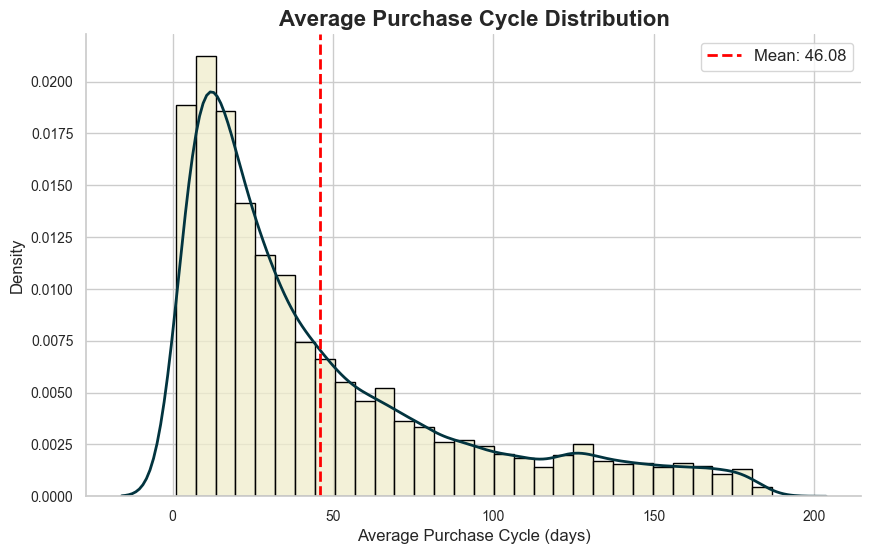

In [ ]:
# 평균 구매 주기 계산
def avg_purchase(merged_df):

    group = merged_df.groupby('customer_id')

    def purchase_cycle(group):
        if len(group) > 1:
            return group['transaction_date'].diff().mean().days
        else:
            return None
        
    df_avg_cycle = group.apply(lambda group: purchase_cycle(group)).reset_index(name = 'avg_pur_cycle').fillna(0)


    # 데이터 준비
    df = df_avg_cycle[df_avg_cycle['avg_pur_cycle'] != 0].copy()

    # 평균 계산
    mean_value = df['avg_pur_cycle'].mean()

    # Seaborn 스타일 설정
    sns.set_theme(style="whitegrid")  # 배경 스타일 설정
    plt.figure(figsize=(10, 6))  # 그래프 크기 설정

    # 히스토그램 생성 (KDE 제외)
    sns.histplot(
        df['avg_pur_cycle'],  # 데이터
        color="#F0EDCC",  # 히스토그램 색상
        bins=30,  # 구간 개수 설정
        edgecolor="black",  # 막대 테두리 색상
        stat="density",  # 밀도로 정규화
        kde=False  # KDE 제외
    )

    # KDE 플롯 추가 (별도 생성)
    sns.kdeplot(
        df['avg_pur_cycle'],  # 데이터
        color="#02343F",  # KDE 선 색상
        linewidth=2  # 선 두께 설정
    )

    # 평균선 추가
    plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')

    # 그래프 제목 및 축 레이블 추가
    plt.title("Average Purchase Cycle Distribution", fontsize=16, fontweight="bold")  # 제목 설정
    plt.xlabel("Average Purchase Cycle (days)", fontsize=12)  # x축 레이블 설정
    plt.ylabel("Density", fontsize=12)  # y축 레이블 설정

    # 축 눈금 스타일 조정
    plt.xticks(fontsize=10)  # x축 눈금 폰트 크기 조정
    plt.yticks(fontsize=10)  # y축 눈금 폰트 크기 조정

    # 그래프 테두리 제거
    sns.despine()  # 상단과 오른쪽 테두리 제거

    # 범례 추가
    plt.legend(fontsize=12)

    # 그래프 표시
    plt.show()

avg_purchase(merged_df)

In [4]:
# 이탈 유저 정의

def get_churn_customer(merged_df):
    # 평균 구매 주기 계산
    group = merged_df.groupby('customer_id')

    def purchase_cycle(group):
        if len(group) > 1:
            return group['transaction_date'].diff().mean().days
        else:
            return None
        
    df_avg_cycle = group.apply(lambda group: purchase_cycle(group)).reset_index(name = 'avg_pur_cycle').fillna(0)


    # 이탈 유저 여부
    df = df_avg_cycle[df_avg_cycle['avg_pur_cycle'] != 0].copy()
    Q1 = df['avg_pur_cycle'].quantile(0.25)  # IQR 계산
    Q3 = df['avg_pur_cycle'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR # 상한선 계산 (이상치 기준)
    print(f"이탈일 기준: {upper_bound}일")
    last_pur = merged_df.groupby('customer_id')[['transaction_date']].max().reset_index()
    last_pur.columns = ['customer_id', 'last_purchase']
    present_day = merged_df['transaction_date'].max() + dt.timedelta(days = 2)  # Timestamp('2022-08-02 00:00:00')
    churn_threshold = dt.timedelta(days = upper_bound) # 현재 데이터 상으로는 141일
    last_pur['is_churned'] = (present_day - last_pur['last_purchase']) > churn_threshold
    last_pur.drop(columns='last_purchase', inplace=True)
    
    return last_pur, upper_bound

last_pur, upper_bound = get_churn_customer(merged_df)

IQR 상한선: 141.5일


#### Cohort <a class="anchor" id="section_1_2"></a>

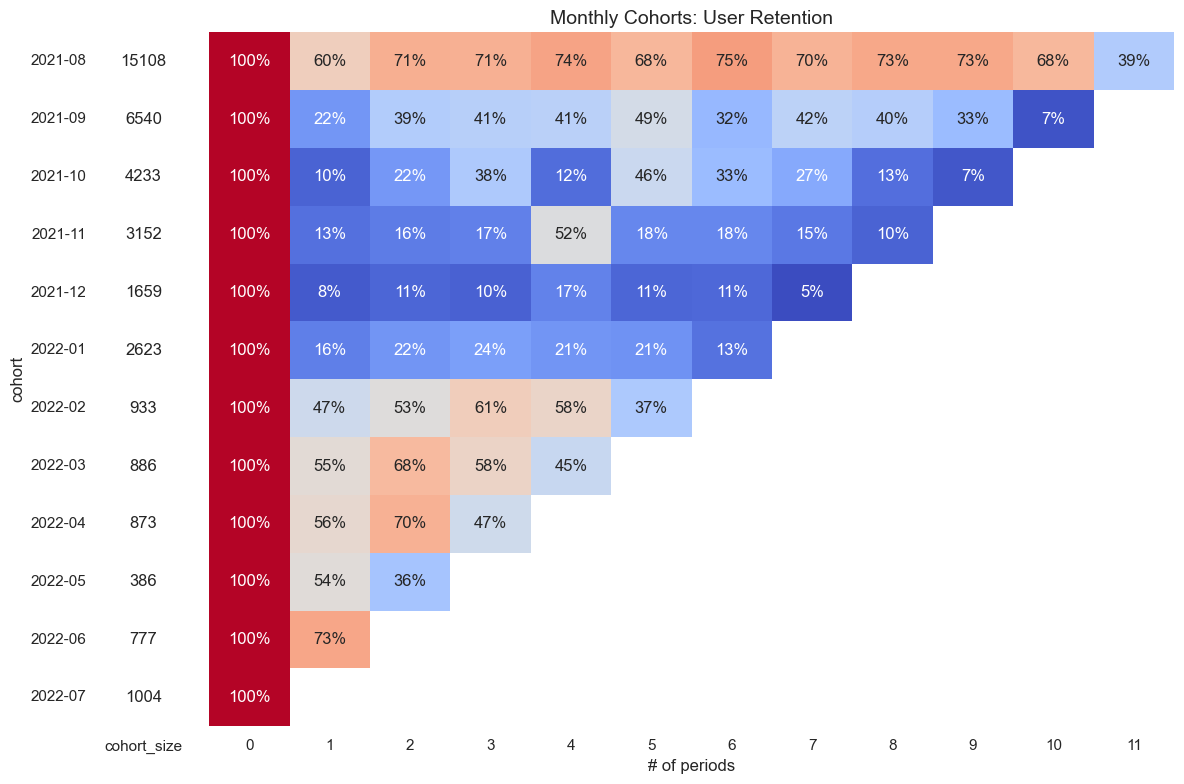

In [ ]:
# 최근 1년 이내 고객 필터링 후 코호트 시각화

def CohortAnalysis(dataframe):
    
   
    data = dataframe.copy()
    data = data[["customer_id", "session_id", "transaction_date"]].drop_duplicates()
    data["order_month"] = data["transaction_date"].dt.to_period("M")
    data["cohort"] = (
        data.groupby("customer_id")["transaction_date"].transform("min").dt.to_period("M")
    )
    cohort_data = (
        data.groupby(["cohort", "order_month"])
        .agg(n_customers=("customer_id", "nunique"))
        .reset_index(drop=False)
    )
    cohort_data["period_number"] = (cohort_data.order_month - cohort_data.cohort).apply(
        attrgetter("n")
    )
    cohort_pivot = cohort_data.pivot_table(
        index="cohort", columns="period_number", values="n_customers"
    )
    cohort_size = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
    with sns.axes_style("white"):
        fig, ax = plt.subplots(
            1, 2, figsize=(12, 8), sharey=True, gridspec_kw={"width_ratios": [1, 11]}
        )
        sns.heatmap(
            retention_matrix,
            mask=retention_matrix.isnull(),
            annot=True,
            cbar=False,
            fmt=".0%",
            cmap="coolwarm",
            ax=ax[1],
        )
        ax[1].set_title("Monthly Cohorts: User Retention", fontsize=14)
        ax[1].set(xlabel="# of periods", ylabel="")
        white_cmap = mcolors.ListedColormap(["white"])
        sns.heatmap(
            pd.DataFrame(cohort_size).rename(columns={0: "cohort_size"}),
            annot=True,
            cbar=False,
            fmt="g",
            cmap=white_cmap,
            ax=ax[0],
        )
        fig.tight_layout()
    
CohortAnalysis(merged_df)

#### RFM Segment <a class="anchor" id="section_1_3"></a>

In [ ]:
# rfm_df 함수 생성
# 지난 1년간 기록을 바탕으로 점수 산정

# rfm dataframe 생성
def rfm(df):

    present_day = df['transaction_date'].max() + dt.timedelta(days = 2)  # Timestamp('2022-08-02 00:00:00')

    rfm = df.groupby('customer_id').agg({'transaction_date': lambda x: (present_day - x.max()).days,
                                        'session_id': lambda x: x.nunique(),
                                        'amount': lambda x: x.sum(),
                                        'first_join_date': lambda x: (present_day - x.max()).days})

    rfm.columns = ['recency', 'frequency', 'monetary', 'join_period']
    rfm = rfm.reset_index()

    return rfm

# rfm score 
def get_rfm_scores(df) -> pd.core.frame.DataFrame:

    # recency 구분
    recency_quantiles = [0.0, 0.25, 0.45, 0.60, 0.75, 1.0]
    recency_bins = df['recency'].quantile(recency_quantiles).tolist()
    df["recency_score"] = pd.cut(df["recency"], bins = recency_bins, labels=[5, 4, 3, 2, 1], include_lowest = True)
    
    # frequency 구분
    df["frequency_score"] = pd.qcut(
        df["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5]
    )
    
    # monetary 구분
    df["monetary_score"] = pd.qcut(df["monetary"], 5, labels=[1, 2, 3, 4, 5])
    
    # 가입 기간 구분
    df["period_score"] = pd.cut(df["join_period"], 
                                bins=[0, 90, 180, 270, 360, float('inf')],
                                labels=[5, 4, 3, 2, 1],
                                right = True)
    
    df['RF_SCORE'] = df["recency_score"].astype(str) + df["frequency_score"].astype(str)
    df["RFM_SCORE"] = df["recency_score"].astype(str) + df["frequency_score"].astype(str) + \
        df["monetary_score"].astype(str)

    return df

# rfm segmentation
def get_segment(df):
    seg_map = {
    r'[1-2][1-2]': 'hibernating', # Hibernating: Recency와 Frequency가 모두 낮은 고객 (오랫동안 거래가 없고 활동이 적음)
    r'[1-2][3-4]': 'at_Risk', # At Risk: Recency가 낮고 Frequency가 중간 수준인 고객 (과거에는 활발했으나 최근 거래가 줄어든 고객)
    r'[1-2]5': 'cant_loose', # Cannot Lose Them: Recency가 낮고 Frequency가 높아 중요한 고객 (이탈 방지가 필요한 고객)
    r'3[1-2]': 'about_to_sleep', # About To Sleep: Recency는 중간 수준이지만 Frequency가 낮은 고객 (거래가 줄어들 가능성이 있는 고객)
    r'33': 'need_attention', # Need Attention: Recency와 Frequency가 모두 중간 수준인 고객 (추가적인 관심이 필요한 고객)
    r'[3-4][4-5]': 'loyal_customers', # Loyal Customers: Recency와 Frequency가 모두 높은 고객 (충성도가 높은 고객)
    r'41|51': 'promising', # Promising: Recency가 높지만 Frequency는 낮은 고객 (잠재적으로 성장 가능성이 있는 신규 또는 초기 고객)
    r'[4-5][2-3]': 'potential_loyalists', # Potential Loyalists: Recency와 Frequency가 중간에서 높은 수준인 고객 (충성도가 높아질 가능성이 있는 고객)
    r'5[4-5]': 'champions' # Champions: Recency와 Frequency가 모두 최고 수준인 VIP 고객 (가장 가치 있는 고객)
}
      
    df['segment'] = df['RF_SCORE'].replace(seg_map, regex = True)
    df.loc[df['period_score'] == 5, 'segment'] = 'new_customers' # New Customers: 가입 기간 점수가 5점인 고객
    
    return df

rfm_df = rfm(merged_df)
rfm_df = get_rfm_scores(rfm_df)
rfm_df = get_segment(rfm_df)

#### 이탈 고객이 매출에 미치는 영향 <a class="anchor" id="section_1_4"></a>

In [ ]:
# customer_id 기준 파생 변수 생성

def get_customer_info(merged_df, customer_df, click_stream_df):

    # 평균 구매 주기 계산
    group = merged_df.groupby('customer_id')

    def purchase_cycle(group):
        if len(group) > 1:
            return group['transaction_date'].diff().mean().days
        else:
            return None
        
    df_avg_cycle = group.apply(lambda group: purchase_cycle(group)).reset_index(name = 'avg_pur_cycle').fillna(0)

    # 고객별 AOV 계산
    df_aov = group['amount'].mean().reset_index(name = 'aov').round(2)

    # 고객별 전환율(total -> booking)
    data = merged_df[['session_id', 'customer_id']]
    df = pd.merge(click_stream_df, data, on='session_id')
    total_session = df.groupby('customer_id')['session_id'].count()
    booking_session = df[df['event_name'] == 'BOOKING'].groupby('customer_id')['session_id'].count()
    conversion_rate = (booking_session / total_session * 100).fillna(0).round(2).reset_index(name = 'conversion_rate')

    # rfm_df
    rfm_df2 = rfm_df[['customer_id', 'recency', 'frequency', 'join_period']]

    # session별 행동 분석
    data = merged_df[['session_id', 'customer_id', 'amount']]
    session_pivot = pd.pivot_table(data = click_stream_df, index='session_id', columns='event_name', values='datetime', aggfunc='count').reset_index().fillna(0)
    session_pivot = session_pivot.merge(data, how='inner', on='session_id')
    session_df = session_pivot.groupby('customer_id').agg\
        (
        CLICK= ('CLICK', 'sum'),
        SCROLL= ('SCROLL', 'sum'),
        SEARCH= ('SEARCH', 'sum'),
        ADD_TO_CART = ('ADD_TO_CART', 'sum'),
        ADD_PROMO = ('ADD_PROMO', 'sum'),
        ITEM_DETAIL = ('ITEM_DETAIL', 'sum'),
        BOOKING = ('BOOKING', 'sum'),
        amount= ('amount', 'sum')
        ).reset_index()
        
    # 고객 특성(성별, 나이, 지역)
    current_date = datetime.now()
    customer = customer_df[['customer_id', 'gender_encoding', 'birthdate', 'home_location_lat', 'home_location_long']].copy()
    customer.loc[:, 'age'] = pd.to_datetime(customer['birthdate']).apply(
        lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day))
    )
    customer.drop(columns=['birthdate'], inplace=True)

    # RFM 고객 세그먼트
    seg = rfm_df[['customer_id', 'segment']].copy()

    # 이탈 유저 여부
    df = df_avg_cycle[df_avg_cycle['avg_pur_cycle'] != 0].copy()
    Q1 = df['avg_pur_cycle'].quantile(0.25)  # IQR 계산
    Q3 = df['avg_pur_cycle'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR # 상한선 계산 (이상치 기준)
    print(f"IQR 상한선: {upper_bound}일")
    last_pur = merged_df.groupby('customer_id')[['transaction_date']].max().reset_index()
    last_pur.columns = ['customer_id', 'last_purchase']
    present_day = merged_df['transaction_date'].max() + dt.timedelta(days = 2)  # Timestamp('2022-08-02 00:00:00')
    churn_threshold = dt.timedelta(days = upper_bound) # 현재 데이터 상으로는 141일
    last_pur['is_churned'] = (present_day - last_pur['last_purchase']) > churn_threshold
    last_pur.drop(columns='last_purchase', inplace=True)

    # 결과 데이터프레임 생성
    customer_info = pd.merge(df_avg_cycle, df_aov, on='customer_id')
    customer_info = customer_info.merge(rfm_df2, on='customer_id')
    customer_info = customer_info.merge(session_df, on='customer_id')
    customer_info = customer_info.merge(customer, on='customer_id')
    customer_info = customer_info.merge(seg, on='customer_id')
    customer_info = customer_info.merge(last_pur, on='customer_id')
    customer_info = customer_info.merge(conversion_rate, on='customer_id')
    
    return customer_info

customer_info = get_customer_info(merged_df, customer_df, click_stream_df)
customer_info

IQR 상한선: 141.5일


,customer_id,avg_pur_cycle,aov,recency,frequency,join_period,CLICK,SCROLL,SEARCH,ADD_TO_CART,ADD_PROMO,ITEM_DETAIL,BOOKING,amount,gender_encoding,home_location_lat,home_location_long,age,segment,is_churned,conversion_rate
0,3,15.0,334832.29,37,12,1438,41.0,21.0,18.0,109.0,13.0,16.0,21.0,7031478,1,-6.151858,106.945839,38,loyal_customers,False,7.42
1,8,76.0,621690.50,79,4,535,9.0,5.0,6.0,5.0,0.0,23.0,4.0,2486762,0,0.970013,124.816832,24,need_attention,False,2.84
2,9,53.0,332583.33,66,5,402,11.0,10.0,4.0,18.0,0.0,6.0,6.0,1995500,0,-6.035939,106.747580,18,need_attention,False,8.82
3,11,0.0,197533.00,148,1,149,1.0,0.0,0.0,4.0,1.0,2.0,1.0,197533,1,1.189610,117.064209,31,hibernating,True,7.14
4,15,0.0,73320.00,209,1,1039,7.0,1.0,2.0,5.0,1.0,1.0,1.0,73320,0,-7.321196,106.653088,41,hibernating,True,4.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38168,99989,60.0,294663.20,121,3,485,0.0,1.0,0.0,10.0,0.0,3.0,5.0,1473316,0,-8.206545,110.874336,27,at_Risk,False,21.74
38169,99991,175.0,295058.50,177,2,528,1.0,4.0,2.0,4.0,0.0,0.0,2.0,590117,0,0.636578,114.175332,36,hibernating,True,10.53
38170,99992,28.0,261039.80,69,5,763,26.0,12.0,6.0,50.0,0.0,1.0,10.0,2610398,0,-4.434246,104.532857,40,need_attention,False,8.55
38171,99995,9.0,327811.27,4,31,716,198.0,95.0,118.0,82.0,12.0,136.0,41.0,13440262,0,-8.196262,110.710026,19,champions,False,4.99


In [ ]:
# 이탈 고객과 활성 고객 통계 비교

# shaipro-walk 정규성 확인
def get_shapiro(segment1, segment2):
    
    from scipy.stats import shapiro

    segment_data1 = customer_info[customer_info['is_churned'] == segment1]['amount']
    segment_data2 = customer_info[customer_info['is_churned'] == segment2]['amount']
    
    segment_data1 = np.log(segment_data1 + 1) # 왜도 심한 경우 로그 변환
    segment_data2 = np.log(segment_data2 + 1) # 왜도 심한 경우 로그 변환

    shapiro1 = shapiro(segment_data1)
    shapiro2 = shapiro(segment_data2)

    print(f"{segment1}: statistic={shapiro1.statistic}, p-value={shapiro1.pvalue}")
    print(f"{segment2}: statistic={shapiro2.statistic}, p-value={shapiro2.pvalue}")

    if shapiro1.pvalue > 0.05 and shapiro2.pvalue > 0.05:
        print("두 그룹 모두 정규성을 만족합니다.")
    else:
        print("정규성을 만족하지 않는 그룹이 있습니다.")
        
    return segment_data1, segment_data2

# 정규성 시각화 확인
def get_normal(segment1, segment2):
    from scipy.stats import probplot

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    probplot(segment1, dist = 'norm', rvalue=True, plot=ax[0])
    ax[0].set_title('rating_Probplot for Normal Distribution')

    probplot(segment2, dist = 'norm', rvalue=True, plot=ax[1])
    ax[1].set_title('rating_Probplot for Normal Distribution')

    plt.tight_layout()
    plt.show()
    
# 분포 검정
def get_mann(segment1, segment2):
    from scipy.stats import mannwhitneyu

    statistic, pvalue = mannwhitneyu(segment1, segment2, alternative = 'less', method = 'auto')

    print(f'mann-whitney statistic: {statistic}')
    print(f'p-value: {pvalue}')

    if pvalue > 0.05:
        print('귀무가설 채택: 두 샘플의 분포는 동일합니다')
    else:
        print('대립가설 채택: 두 샘플의 분포는 다릅니다')

# T-test 함수
def get_ttest(segment1, segment2):
    from scipy.stats import ttest_ind

    # T-test 수행 (equal_var=False는 Welch's t-test를 수행)
    statistic, pvalue = ttest_ind(segment1, segment2, equal_var=False, alternative='less')

    print(f'T-test statistic: {statistic}')
    print(f'p-value: {pvalue}')

    if pvalue > 0.05:
        print('귀무가설 채택: 두 샘플의 평균은 동일합니다')
    else:
        print('대립가설 채택: 두 샘플의 평균은 다릅니다')        
        
# 시각화로 확인
def get_kde(segment1, segment2):
    mean1 = np.mean(segment1)
    mean2 = np.mean(segment2)
    plt.figure(figsize=(12, 6))
    sns.histplot(segment1, color="blue", label='segment1', kde=True)
    sns.histplot(segment2, color="orange", label='segment2', kde=True)
    plt.axvline(mean1, color='blue', linestyle='--', label=f'Segment 1 Mean: {mean1:.2f}')
    plt.axvline(mean2, color='orange', linestyle='--', label=f'Segment 2 Mean: {mean2:.2f}')
    plt.legend()
    plt.title("Conversion Ratings by Segment")
    plt.show()

True: statistic=0.9733993411064148, p-value=1.8477451485663822e-39
False: statistic=0.9946494102478027, p-value=2.827563451806927e-30
정규성을 만족하지 않는 그룹이 있습니다.


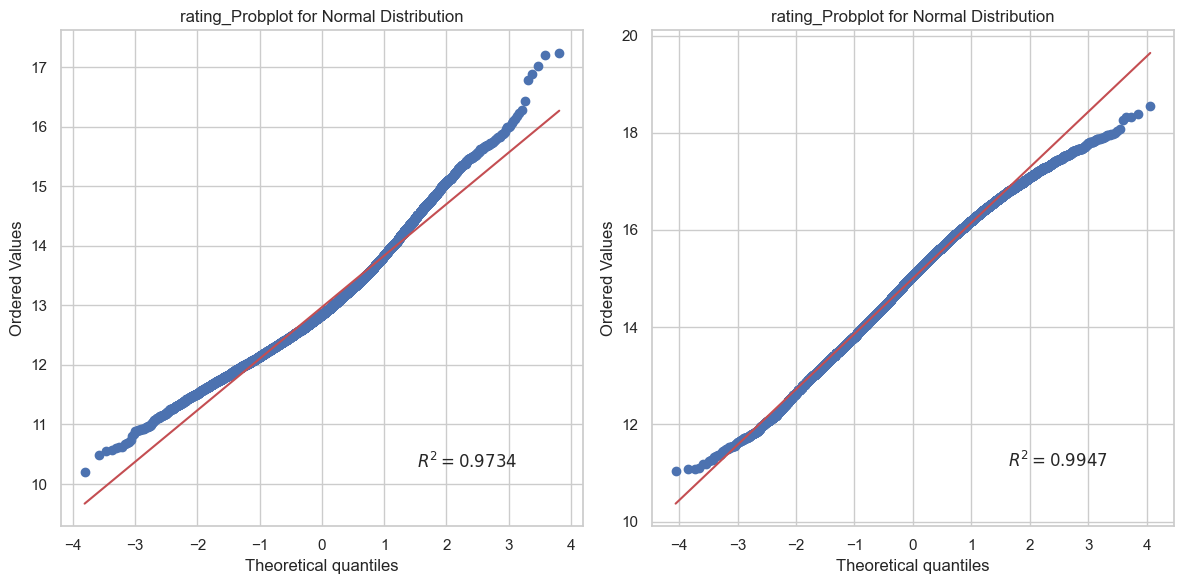

mann-whitney statistic: 24254703.5
p-value: 0.0
대립가설 채택: 두 샘플의 분포는 다릅니다
T-test statistic: -183.31159659570892
p-value: 0.0
대립가설 채택: 두 샘플의 평균은 다릅니다


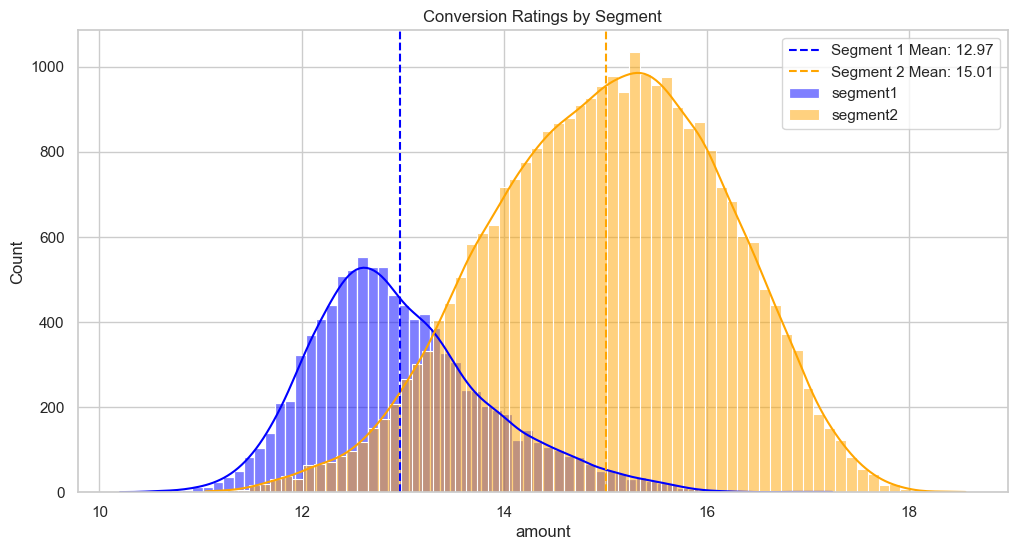

In [ ]:
True_data, False_data = get_shapiro(True, False)
get_normal(True_data, False_data)
get_mann(True_data, False_data)
get_ttest(True_data, False_data)
get_kde(True_data, False_data)

#### 회귀분석 <a class="anchor" id="section_1_5"></a>

In [5]:
# 최근 3회 거래 기준, customer_id 기준 파생 변수 생성
def get_merged_data(merged_df, click_stream_df):
    from dateutil.relativedelta import relativedelta
    
    data = merged_df.copy()
    # 마지막 3일의 거래 데이터 추출
    last3_dates = data.groupby('customer_id')['transaction_date'].unique().apply(lambda x: x[-3:]).explode()
    last3_dates_df = last3_dates.reset_index().rename(columns={0: 'transaction_date'})
    last_3_data = pd.merge(data, last3_dates_df, on=['customer_id', 'transaction_date'])

    # 행동 양상 데이터 결합
    data = pd.pivot_table(click_stream_df, index='session_id', columns=['event_name'], values='datetime', aggfunc='count').reset_index().fillna(0)
    traffic_data = pd.pivot_table(click_stream_df, index='session_id', columns='traffic_source').reset_index().fillna(0)
    traffic_data.columns = ['session_id', 'mobile', 'web']
    data = data.merge(traffic_data, on='session_id')

    last_3_data.drop_duplicates(inplace=True)
    merged_data = last_3_data.merge(data, how='inner', on='session_id')
    
    # 고객별 AOV 계산
    df_aov = merged_df.groupby('customer_id')['amount'].mean().reset_index(name = 'aov').round(2)

    # 고객별 전환율(total -> booking)
    data = merged_df[['session_id', 'customer_id']]
    df = pd.merge(click_stream_df, data, on='session_id')
    total_session = df.groupby('customer_id')['session_id'].count()
    booking_session = df[df['event_name'] == 'BOOKING'].groupby('customer_id')['session_id'].count()
    conversion_rate = (booking_session / total_session * 100).fillna(0).round(2).reset_index(name = 'conversion_rate')

    # 고객 특성(나이)
    current_date = datetime.now()
    merged_data.loc[:, 'age'] = pd.to_datetime(merged_data['birthdate']).apply(
        lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day))
    )
    merged_data.drop(columns=['birthdate'], inplace=True)

    # 가입 기간(개월)
    def get_months(dt_origin, format = '%d-%m-%Y'):
        present_day = merged_df['transaction_date'].max() + dt.timedelta(days = 2)
        delta = relativedelta(present_day, dt_origin)
        return delta.months + (delta.years * 12)

    merged_data['join_period'] = merged_data['first_join_date'].apply(get_months)
    
    # 배송 기간
    merged_data['ship_duration'] = (merged_data['shipment_date'] - merged_data['transaction_date']).dt.days
    
    # 삭제 컬럼
    col = ['product_id', 'season_encoding', 'target_sex_encoding', 'transaction_date', 'transaction_time', 'shipment_date', 'shipment_time', 'original_index', 'first_name', 'first_join_date', 'last_name', 'device_id', 'booking_id', 'home_location', 'articleType', 'subCategory', 'baseColour', 'season', 'year', 'productDisplayName']
    merged_data.drop(columns = col, inplace = True)

    # 결과 데이터프레임 생성
    merged_data = pd.merge(merged_data, df_aov, on='customer_id')
    merged_data = merged_data.merge(last_pur, on='customer_id')
    merged_data = merged_data.merge(conversion_rate, on='customer_id')

    # 범주형 데이터 원핫인코딩
    device_type = pd.get_dummies(merged_data['device_type'], prefix="Device", dtype=int)
    payment_method = pd.get_dummies(merged_data['payment_method'], prefix="Pay", dtype=int)
    payment_status = pd.get_dummies(merged_data['payment_status'], prefix="status", dtype=int)
    promo_code = pd.get_dummies(merged_data['promo_code'], prefix="Promo", dtype=int)
    target_sex = pd.get_dummies(merged_data['target_sex'], prefix="Target", dtype=int)
    usage = pd.get_dummies(merged_data['usage'], prefix="usage", dtype=int)
    masterCategory = pd.get_dummies(merged_data['masterCategory'], prefix="Category", dtype=int)

    # 원래 컬럼 삭제
    merged_data_anal = merged_data.drop(columns=[
        'device_type', 
        'payment_method', 
        'payment_status', 
        'promo_code', 
        'target_sex', 
        'usage', 
        'masterCategory'
    ])

    merged_data_anal = pd.concat([merged_data_anal, 
                                device_type, 
                                payment_method, 
                                payment_status,
                                promo_code,
                                target_sex,
                                usage,
                                masterCategory
                                ], axis=1)
    
    return merged_data, merged_data_anal

# 최종 데이터프레임 생성
def get_final_df(merged_data_anal):
    # 복사본 생성 및 불필요한 열 제거
    df = merged_data_anal.copy()
    df.drop(columns=['session_id'], inplace=True)  # session_id 제거
    df['is_churned'] = df['is_churned'].astype(int)  # is_churned 변환

    # 특정 컬럼에 대해 sum을 적용
    aggfunc_sum = {
        'ADD_PROMO': 'sum',
        'ADD_TO_CART': 'sum',
        'BOOKING': 'sum',
        'CLICK': 'sum',
        'HOMEPAGE': 'sum',
        'ITEM_DETAIL': 'sum',
        'PROMO_PAGE': 'sum',
        'SCROLL': 'sum',
        'SEARCH': 'sum',
        'amount': 'sum',
        'quantity': 'sum',
        'shipment_fee': 'sum'
    }

    # 나머지 숫자형 컬럼에 대해 mean을 적용
    all_columns = df.drop(columns = 'customer_id').select_dtypes(include=['number']).columns.tolist()  # 숫자형 열만 선택
    aggfunc = {col: aggfunc_sum.get(col, 'mean') for col in all_columns}  # sum 또는 mean 설정

    # Pivot Table 생성 (한 번에 처리)
    pivot_result = pd.pivot_table(data=df, index=['customer_id'], aggfunc=aggfunc).reset_index()

    return pivot_result

merged_data, merged_data_anal = get_merged_data(merged_df, click_stream_df)
final = get_final_df(merged_data_anal)

컬럼별 이상치 갯수: {'amount': 829}


train 정확도: 0.7661301397875808
test 정확도: 0.7575047948775473


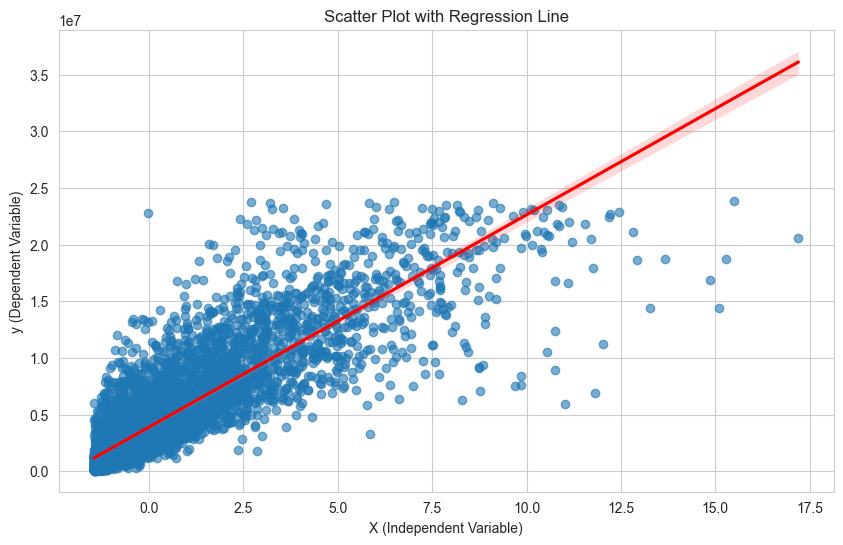

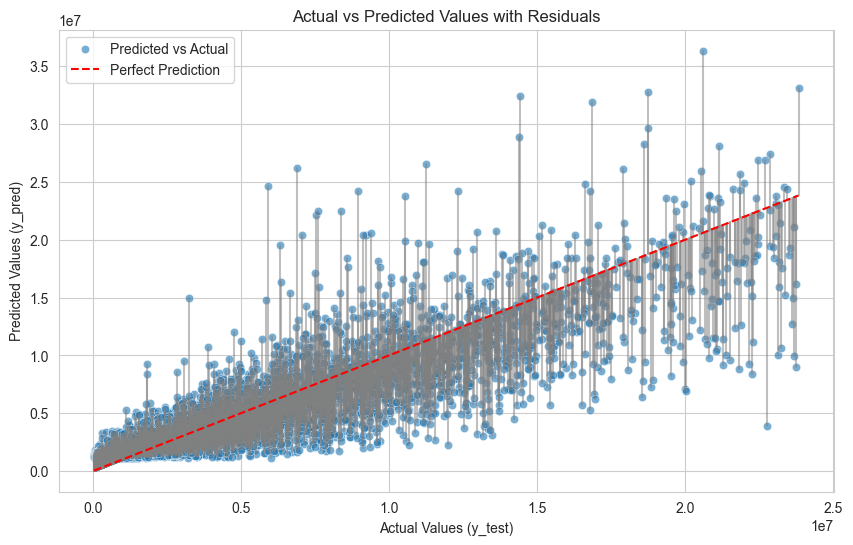

Mean Squared Error (MSE): 5267848037000.61
Mean Absolute Error (MAE): 1489290.65
R^2 Score: 0.76


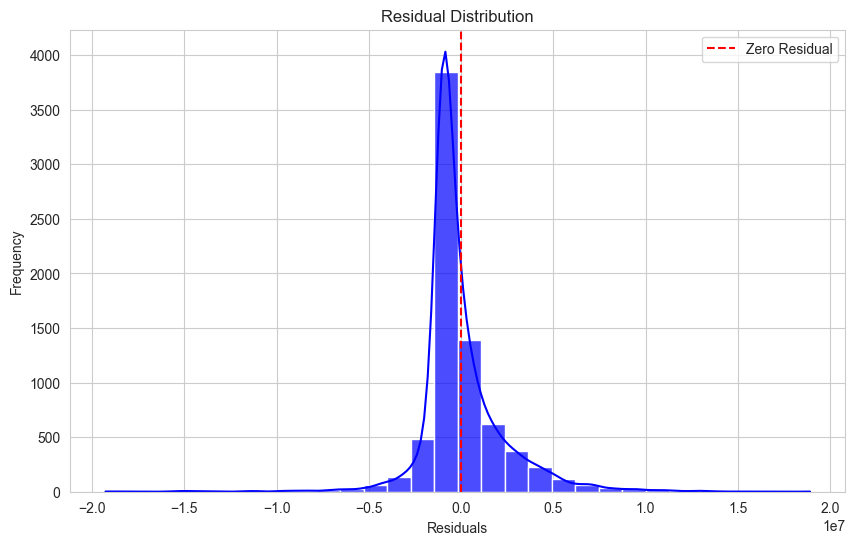

In [ ]:
# 회귀분석 함수
def get_linear_regression(X, y, n_components = 1):

    # 훈련 및 테스트 데이터 분리

    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from sklearn.decomposition import PCA

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # PCA 적용
    pca = PCA(n_components=n_components)  # n_components: 축소할 차원 수
    X_pca = pca.fit_transform(X_scaled)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)

    # 모델 예측
    y_pred_lr = model_lr.predict(X_test)

    # 정확도 측정
    print('train 정확도:', model_lr.score(X_train, y_train))

    # 정확도 측정
    print('test 정확도:', model_lr.score(X_test, y_test))

    # 산점도와 회귀선 그리기
    plt.figure(figsize=(10, 6))
    sns.regplot(x=X_test, y=y_test, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    plt.title("Scatter Plot with Regression Line")
    plt.xlabel("X (Independent Variable)")
    plt.ylabel("y (Dependent Variable)")
    plt.show()
    
    # # 모든 변수의 회귀선 그리기
    # for i in range(X.shape[1]):
    #     plt.figure(figsize=(10, 6))
    #     sns.regplot(x=X_scaled[:, i], y=y, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
    #     plt.title(f"Scatter Plot with Regression Line (Feature {i+1})")
    #     plt.xlabel(f"Feature {i+1}")
    #     plt.ylabel("y (Dependent Variable)")
    #     plt.show()

    # 실제 값 vs 예측 값과 잔차 표시
    plt.figure(figsize=(10, 6))

    # 산점도: 실제 값 vs 예측 값
    sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.6, label="Predicted vs Actual")

    # 잔차를 선으로 연결
    for i in range(len(y_test)):
        plt.plot([y_test.iloc[i], y_test.iloc[i]], [y_test.iloc[i], y_pred_lr[i]], color='gray', alpha=0.5)

    # 대각선(완벽한 예측선)
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red', linestyle='--', label="Perfect Prediction")

    plt.title('Actual vs Predicted Values with Residuals')
    plt.xlabel('Actual Values (y_test)')
    plt.ylabel('Predicted Values (y_pred)')
    plt.legend()
    plt.show()
    
    # 평가 지표 계산
    mse = mean_squared_error(y_test, y_pred_lr)  # 평균 제곱 오차
    mae = mean_absolute_error(y_test, y_pred_lr)  # 평균 절대 오차
    r2 = r2_score(y_test, y_pred_lr)  # R^2 점수

    # 평가 지표 출력
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    residuals = y_test - y_pred_lr

    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=30, color='blue', alpha=0.7)
    plt.axvline(x=0, color='red', linestyle='--', label="Zero Residual")
    plt.title('Residual Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Z-score 이상치 제거
def get_outlier_zscore(df):
    col = ['amount']
    zscore_cnt = {}
    from scipy import stats
    
    for column in col:
        mean = df[column].mean()
        std = df[column].std()
        z_scores = (df[column] - mean) / std
        abs_z_scores = np.abs(z_scores)
        threshold = 3
        outlier = abs_z_scores > threshold
        inlier = abs_z_scores <= threshold
        
        outlier_cnt = df[outlier].shape[0]
        zscore_cnt[column] = outlier_cnt
        
        df = df.loc[inlier]
        
        print('컬럼별 이상치 갯수:', zscore_cnt)
        
    return df

# 독립변수, 종속변수 선언
df = customer_info.copy()
lr_df = get_outlier_zscore(df)

X = lr_df[['CLICK', 'SCROLL', 'SEARCH', 'ADD_TO_CART', 'ADD_PROMO',
       'ITEM_DETAIL']]
# X['mean'] = (X.sum(axis=1) / X.columns.nunique()).round(2)
y = lr_df['amount']

# get_linear_regression(X[['mean']], y)
get_linear_regression(X, y, n_components = 1)

#### 고객 행동 분석 <a class="anchor" id="section_1_6"></a>

In [ ]:
# 지난 이탈 기준일 ~ 이탈 기준일*2 거래 데이터 정리

click_stream_df['event_date'] = pd.to_datetime(click_stream_df['event_date'])
present_day = merged_df['transaction_date'].max() + dt.timedelta(days = 2)  # Timestamp('2022-08-02 00:00:00')
last_churn_days = present_day - dt.timedelta(days = upper_bound)
last_churn2_days = present_day - dt.timedelta(days = (upper_bound*2))

mask1 = (merged_df['transaction_date'] >= last_churn2_days) & (merged_df['transaction_date'] < last_churn_days)
mask2 = (click_stream_df['event_date'] >= last_churn2_days) & (click_stream_df['event_date'] < last_churn_days)
merged82 = merged_df[mask1]
click_stream82 = click_stream_df[mask2]

In [ ]:
# 지난 이탈 기준일 ~ 이탈 기준일*2 거래 데이터 정리 customer_id 기준 파생 변수 생성
# 고객별 거래 건마다 건 수 기록하는 컬럼?

def get_behavior(merged_df, customer_df, click_stream_df):
    
    # 고객별 AOV 계산
    df_aov = merged_df.groupby('customer_id')['amount'].mean().reset_index(name = 'aov').round(2)

    # session별 행동 분석
    data = merged_df[['session_id', 'customer_id', 'amount']]
    session_pivot = pd.pivot_table(data = click_stream_df, index='session_id', columns='event_name', values='datetime', aggfunc='count').reset_index().fillna(0)
    session_pivot = session_pivot.merge(data, how='inner', on='session_id')
    session_df = session_pivot.groupby('customer_id').agg\
        (
        CLICK= ('CLICK', 'sum'),
        SCROLL= ('SCROLL', 'sum'),
        SEARCH= ('SEARCH', 'sum'),
        ADD_TO_CART = ('ADD_TO_CART', 'sum'),
        ADD_PROMO = ('ADD_PROMO', 'sum'),
        ITEM_DETAIL = ('ITEM_DETAIL', 'sum'),
        BOOKING = ('BOOKING', 'sum'),
        amount= ('amount', 'sum')
        ).reset_index()
        
    # 고객 특성(성별, 나이, 지역)
    current_date = datetime.now()
    customer = customer_df[['customer_id', 'gender_encoding', 'birthdate', 'home_location_lat', 'home_location_long']].copy()
    customer.loc[:, 'age'] = pd.to_datetime(customer['birthdate']).apply(
        lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day))
    )
    customer.drop(columns=['birthdate'], inplace=True)
 
    # 결과 데이터프레임 생성
    result = pd.merge(session_df, df_aov, on='customer_id')
    result = result.merge(customer, on='customer_id')
     
    # 행동 특성 파생변수 생성
    behavior_df = result.copy()
    
    # 전체 활동 총합
    col = ['CLICK', 'SCROLL', 'SEARCH', 'ADD_TO_CART', 'ADD_PROMO', 'ITEM_DETAIL']
    behavior_df['total_activity'] = behavior_df[col].sum(axis = 1)

    # 활동 총합 대비 구매 비율
    behavior_df['activity_ratio'] = behavior_df.apply(
    lambda row: row['BOOKING'] if row['total_activity'] == 0 and row['BOOKING'] > 0 
                    else (row['BOOKING'] / row['total_activity'] 
                          if row['total_activity'] > 0 
                          else 0),
                            axis=1
                            )
    behavior_df['activity_ratio'].fillna(0, inplace=True)

    # 평균 구매 금액 대비 총 구매 금액 비율
    behavior_df['amount_to_aov'] = behavior_df['amount'] / behavior_df['aov']
    behavior_df['amount_to_aov'].fillna(0, inplace=True)

    # 인도네시아 수도(자카르타) 기준 거리 계산
    center_lat, center_long = -6.2088, 106.8456
    behavior_df['distance_from_center'] = np.sqrt(
        (behavior_df['home_location_lat'] - center_lat)**2 +
        (behavior_df['home_location_long'] - center_long)**2
    )
    
    # 고객 정보 종합 merge
    col = ['customer_id', 'avg_pur_cycle', 'recency', 'join_period', 'segment']
    behavior_df = behavior_df.merge(customer_info[col], how='inner', on='customer_id')
    
    # 고객 평균 구매 주기 대비 최근 거래일
    behavior_df['recency_ratio'] = behavior_df.apply(
    lambda row: row['recency'] if row['avg_pur_cycle'] == 0 and row['recency'] > 0 
                    else (row['recency'] / row['avg_pur_cycle'] 
                          if row['avg_pur_cycle'] > 0 
                          else 0),
                            axis=1
                            )
    behavior_df['recency_ratio'].fillna(0, inplace=True)
    
    # 이탈 고객
    churn = last_pur[['customer_id', 'is_churned']]
    behavior_df = behavior_df.merge(churn, on='customer_id')
    
    return result, behavior_df

result, behavior_df = get_behavior(merged82, customer_df, click_stream82)
behavior_df.head()

,customer_id,CLICK,SCROLL,SEARCH,ADD_TO_CART,ADD_PROMO,ITEM_DETAIL,BOOKING,amount,aov,gender_encoding,home_location_lat,home_location_long,age,total_activity,activity_ratio,amount_to_aov,distance_from_center,avg_pur_cycle,recency,join_period,segment,recency_ratio,is_churned
0,3,14.0,10.0,9.0,40.0,4.0,5.0,9.0,2354002,261555.78,1,-6.151858,106.945839,38,82.0,0.109756,9.0,0.115283,15.0,37,1438,loyal_customers,2.466667,False
1,8,3.0,1.0,2.0,2.0,0.0,0.0,2.0,1128165,564082.50,0,0.970013,124.816832,24,8.0,0.250000,2.0,19.352016,76.0,79,535,need_attention,1.039474,False
2,9,7.0,4.0,4.0,8.0,0.0,0.0,3.0,1179050,393016.67,0,-6.035939,106.747580,18,23.0,0.130435,3.0,0.198718,53.0,66,402,need_attention,1.245283,False
3,11,1.0,0.0,0.0,4.0,1.0,2.0,1.0,197533,197533.00,1,1.189610,117.064209,31,8.0,0.125000,1.0,12.615722,0.0,148,149,hibernating,148.000000,True
4,15,7.0,1.0,2.0,5.0,1.0,1.0,1.0,73320,73320.00,0,-7.321196,106.653088,41,17.0,0.058824,1.0,1.128931,0.0,209,1039,hibernating,209.000000,True


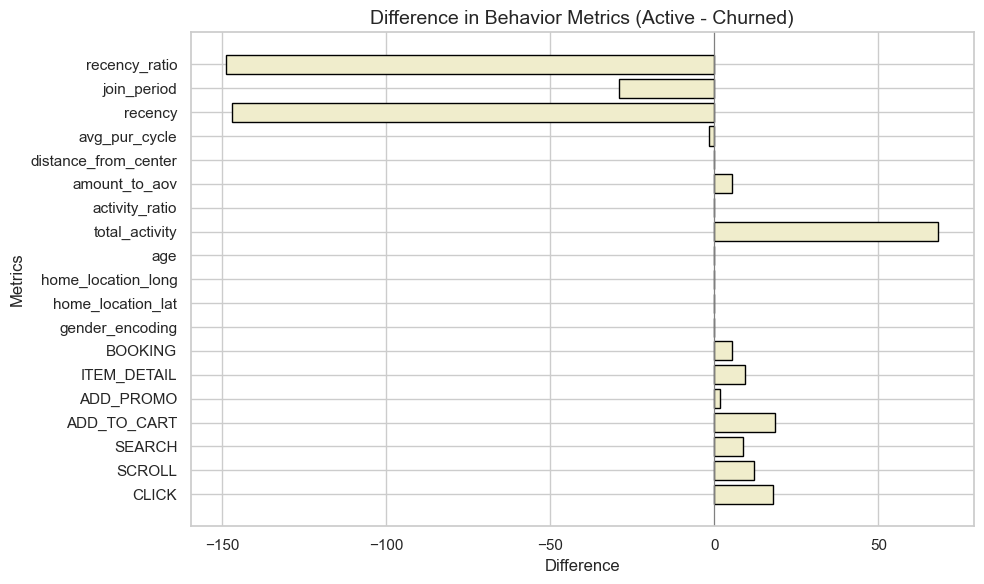

In [ ]:
# 이탈 고객과 활성 고객의 행동 패턴 비교

# 그룹화
grouped = behavior_df.groupby('is_churned').mean().round(2)

# 이탈 고객과 활성 고객의 행동 지표 비교
diff = grouped.loc[False] - grouped.loc[True]

# 데이터 준비
diff = dict(diff)
# customer_id와 amount 제외
filtered_diff = {key: value for key, value in diff.items() if key not in ["customer_id", "amount", "aov"]}
metrics = list(filtered_diff.keys())
values = list(filtered_diff.values())

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color='#F0EDCC', edgecolor='black')
plt.axvline(0, color='gray', linewidth=0.8)  # 기준선(0)
plt.title("Difference in Behavior Metrics (Active - Churned)", fontsize=14)
plt.xlabel("Difference", fontsize=12)
plt.ylabel("Metrics", fontsize=12)
plt.tight_layout()

# 그래프 출력
plt.show()

#### 이탈 예측 머신러닝 정확도 개선 <a class="anchor" id="section_1_7"></a>

In [9]:
# 상관관계 높은 변수 확인 및 제거
def get_corr_reduced(final):
    df = final.copy()
    # 상관관계 행렬 생성
    correlation_matrix = df.corr()

    # 상관계수 임계값 설정 (예: 0.8)
    threshold = 0.86

    # 상관관계가 높은 변수 쌍 확인
    high_correlation_pairs = []
    for i in range(correlation_matrix.shape[0]):
        for j in range(i + 1, correlation_matrix.shape[1]):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                high_correlation_pairs.append((correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

    # 상관관계가 높은 변수 출력
    print("상관관계가 높은 변수 쌍:")
    for pair in high_correlation_pairs:
        print(f"{pair[0]} - {pair[1]}: {pair[2]:.2f}")
        
    # 상관관계가 높은 변수 중 하나를 제거
    def remove_highly_correlated_features(df, correlation_matrix, threshold=0.8):
        columns_to_remove = set()
        for i in range(correlation_matrix.shape[0]):
            for j in range(i + 1, correlation_matrix.shape[1]):
                if abs(correlation_matrix.iloc[i, j]) > threshold:
                    # 두 변수 중 하나를 선택하여 제거 (예: 두 번째 변수)
                    columns_to_remove.add(correlation_matrix.columns[j])
        return df.drop(columns=columns_to_remove)

    # 상관관계가 높은 변수 제거 후 데이터프레임 반환
    df_reduced = remove_highly_correlated_features(df, correlation_matrix, threshold=threshold)

    print(f"제거된 컬럼 수: {len(df.columns) - len(df_reduced.columns)}")
    print(f"최종 컬럼 수: {len(df_reduced.columns)}")
    
    return df_reduced

# pca로 공선성 높은 변수 합친 최종 데이터
def get_pca_df(df_reduced):

    from sklearn.cluster import AgglomerativeClustering
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA

    
    X = df_reduced.drop(columns = ['customer_id', 'is_churned', 'amount'])
    y_churn = df_reduced['is_churned']
    y_amount = df_reduced['amount']
    
    # Step 1: 데이터 표준화
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X)

    # Step 2: 상관관계 행렬 계산
    correlation_matrix = np.corrcoef(scaled_data, rowvar=False)
    correlation_matrix = np.nan_to_num(correlation_matrix)

    # Step 3: 계층적 클러스터링을 사용하여 변수 그룹화
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1.0, metric='euclidean', linkage='ward')
    clustering.fit(correlation_matrix)

    # 클러스터별 변수 그룹 생성
    clusters = {}
    for idx, label in enumerate(clustering.labels_):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(X.columns[idx])

    print("클러스터 결과:", clusters)

    # Step 4: 각 클러스터에 대해 PCA 적용
    pca_results = pd.DataFrame(index = X.index)

    for cluster_id, variables in clusters.items():
        if len(variables) > 1:  # 클러스터에 변수가 여러 개인 경우 PCA 적용
            pca = PCA(n_components=1)
            pca_result = pca.fit_transform(X[variables])
            # NumPy 배열로 변환 후 평탄화하여 DataFrame에 저장
            pca_results[f'PCA_Cluster_{cluster_id}'] = pd.Series(pca_result.flatten(), index=X.index)
        else:
            # 클러스터에 변수가 하나인 경우 그대로 유지
            pca_results[variables[0]] = X[variables]
            
    
    # Step 5: PCA 결과와 원본 데이터 결합 (PCA에 사용된 변수 제외)
    remaining_columns = [col for col in X.columns if col not in [var for cluster in clusters.values() for var in cluster]]
    X_pca = pd.concat([X[remaining_columns], pca_results], axis=1)

    return X_pca, y_churn, y_amount

df_reduced = get_corr_reduced(final)
X_pca, y_churn, y_amount = get_pca_df(df_reduced)


상관관계가 높은 변수 쌍:
CLICK - SCROLL: 0.87
Category_Home - usage_Home: 1.00
Device_Android - Device_iOS: -1.00
amount - quantity: 0.95
status_Failed - status_Success: -1.00
제거된 컬럼 수: 5
최종 컬럼 수: 62
클러스터 결과: {49: ['ADD_PROMO'], 9: ['ADD_TO_CART', 'BOOKING'], 2: ['CLICK', 'HOMEPAGE', 'ITEM_DETAIL', 'PROMO_PAGE', 'SEARCH'], 48: ['Category_Accessories'], 25: ['Category_Apparel'], 46: ['Category_Footwear'], 32: ['Category_Free Items'], 50: ['Category_Home'], 24: ['Category_Personal Care'], 33: ['Category_Sporting Goods'], 47: ['Device_Android'], 29: ['Pay_Credit Card'], 41: ['Pay_Debit Card'], 39: ['Pay_Gopay'], 23: ['Pay_LinkAja'], 37: ['Pay_OVO'], 45: ['Promo_AZ2022'], 44: ['Promo_BUYMORE'], 28: ['Promo_LIBURDONG'], 11: ['Promo_Nothing'], 30: ['Promo_SC2022'], 26: ['Promo_STARTUP'], 43: ['Promo_WEEKENDMANTAP'], 22: ['Promo_WEEKENDSERU'], 12: ['Promo_XX2022'], 14: ['Target_Boys'], 27: ['Target_Girls'], 35: ['Target_Men'], 34: ['Target_Unisex'], 21: ['Target_Women'], 38: ['age'], 0: ['aov', 'item_p

In [ ]:
# # 변수 측정 1. mutual_information
# def get_mutual_information(X_trans, y):

#     # 1. Mutual Information
#     from sklearn.feature_selection import mutual_info_classif
#     from sklearn.feature_selection import SelectKBest

#     # 데이터 표준화
#     scaler = StandardScaler()
#     X_trans = scaler.fit_transform(X_trans)
    
#     # Mutual Information 계산
#     mi_scores = mutual_info_classif(X_trans, y)
    
#     # k개 feature 선택
#     k_best_selector = SelectKBest(score_func=mutual_info_classif, k=10)
#     X_selected = k_best_selector.fit_transform(X_trans, y)
#     selected_features = k_best_selector.get_support(indices=True)

#     # Mutual Information 점수 시각화
#     plt.bar(range(len(mi_scores)), mi_scores)
#     plt.xlabel('Feature Index')
#     plt.ylabel('Mutual Information Score')
#     plt.title('Feature Importance based on Mutual Information')
#     plt.show()

#     # 데이터프레임 확인
#     print(X_trans.iloc[:, selected_features])
    
#     return selected_features

# # 2. RFECV
# def get_rfecv(X_trans, y):
#     from sklearn.feature_selection import RFECV
#     from sklearn.ensemble import RandomForestClassifier
#     from sklearn.model_selection import StratifiedKFold

#     # 데이터 표준화
#     scaler = StandardScaler()
#     X_trans = scaler.fit_transform(X_trans)

#     # 랜덤포레스트와 RFECV 실행
#     estimator = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
#     cv = StratifiedKFold(5)
#     rfecv = RFECV(estimator=estimator, step=5, cv=cv, scoring='f1', min_features_to_select=5, n_jobs=-1)
#     rfecv.fit(X_trans, y)

#     # 결과 출력
#     print("Optimal number of features:", rfecv.n_features_)
    
#     # 데이터프레임 확인
#     print(X_trans.iloc[:, rfecv.support_])
    
#     # 선택된 변수와 중요도 추출
#     selected_features = X_trans.columns[rfecv.support_]  # RFECV가 선택한 변수
#     feature_importances = rfecv.estimator_.feature_importances_  # 선택된 변수의 중요도

#     # 데이터프레임 생성 (변수 이름과 중요도)
#     importance_df = pd.DataFrame({
#         "Feature": selected_features,
#         "Importance": feature_importances
#     }).sort_values(by="Importance", ascending=False)

#     # 시각화
#     plt.figure(figsize=(10, 6))
#     plt.barh(importance_df["Feature"], importance_df["Importance"], color="#F0EDCC")
#     plt.xlabel("Feature Importance")
#     plt.ylabel("Features")
#     plt.title("Feature Importance from RFECV")
#     plt.gca().invert_yaxis()  # 상위 중요도가 위로 오도록 정렬
#     plt.tight_layout()
#     plt.show()
    
#     return rfecv.support_
    
# # X_trans = get_trans_X_y(X_pca)
# selected_features = get_mutual_information(X_pca, y_churn)
# rfecv_support_ = get_rfecv(X_pca, y_churn)

# print(X_pca.iloc[:, selected_features].columns)
# print(X_pca.iloc[:, rfecv_support_].columns)

In [ ]:
# print(X_trans.iloc[:, selected_features].columns)
# print(X_trans.iloc[:, rfecv_support_].columns)

In [39]:
# rfecv 변수 선택
# AutoGluon 모델링(sklearn 1.4.0버전이어야 함. 현재는 1.6.1)

col = ['PCA_Cluster_9', 'PCA_Cluster_2', 'Target_Men', 'conversion_rate',
       'join_period', 'shipment_fee']

def get_autogluon(X_trans, y):
    
    # Step 1: 데이터 표준화
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_trans)
    
    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X_scaled[col], y, test_size=0.2, random_state=42, stratify=y)

    # SMOTE 객체 생성 및 적용
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    from autogluon.tabular import TabularPredictor
    train_data = pd.concat([X_train, y_train], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)
    predictor = TabularPredictor(label='is_churned', problem_type = 'binary', eval_metric='precision',).fit(train_data)

    # 테스트 데이터로 평가
    performance = predictor.evaluate(test_data)
    print(performance)

    # 예측 결과 확인 (테스트 데이터에 대한 확률 출력)
    predictions = predictor.predict_proba(test_data)
    print(predictions.head())
    
    y_pred = predictor.predict(X_test)  # 실제 값과 예측 값
    y_prob = predictor.predict_proba(X_test).iloc[:, 1]
    
    return X_train, X_test, y_train, y_test, predictor, y_pred, y_prob
   
X_train, X_test, y_train, y_test, predictor, y_pred, y_prob = get_autogluon(X_pca, y_churn)


No path specified. Models will be saved in: "AutogluonModels/ag-20250127_070701/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20250127_070701/"
AutoGluon Version:  0.8.3
Python Version:     3.9.13
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 23.5.0: Wed May  1 20:16:51 PDT 2024; root:xnu-10063.121.3~5/RELEASE_ARM64_T8103
Disk Space Avail:   59.17 GB / 245.11 GB (24.1%)
Train Data Rows:    45012
Train Data Columns: 6
Label Column: is_churned
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1309.06 MB
	Train Data (Original)  Memory Usage: 2.16 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitti

{'precision': 0.9065817409766455, 'accuracy': 0.9376555337262606, 'balanced_accuracy': 0.909659920828504, 'mcc': 0.8366843606056791, 'roc_auc': 0.9779942784398217, 'f1': 0.8776978417266187, 'recall': 0.850597609561753}
              0         1
4559   0.410858  0.589142
38142  0.984077  0.015923
36255  0.033165  0.966835
18770  0.901767  0.098233
21880  0.957958  0.042042


In [82]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca[col])

# 테스트 데이터에 대한 예측 수행
predictions = predictor.predict(X_scaled)  # 이탈 여부 (0 또는 1)
probabilities = predictor.predict_proba(X_scaled)  # 이탈 확률 (0~1)

# 결과 확인
print("Predictions (이탈 여부):")
print(predictions.head())
print("\nProbabilities (이탈 확률):")
print(probabilities.head())


Predictions (이탈 여부):
0    0
1    0
2    0
3    1
4    1
Name: is_churned, dtype: int64

Probabilities (이탈 확률):
          0         1
0  0.963403  0.036597
1  0.991589  0.008411
2  0.943068  0.056932
3  0.360105  0.639895
4  0.053551  0.946449


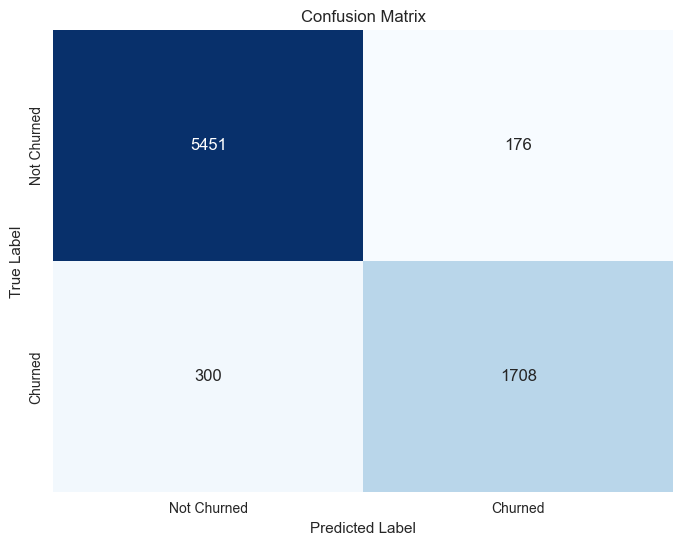

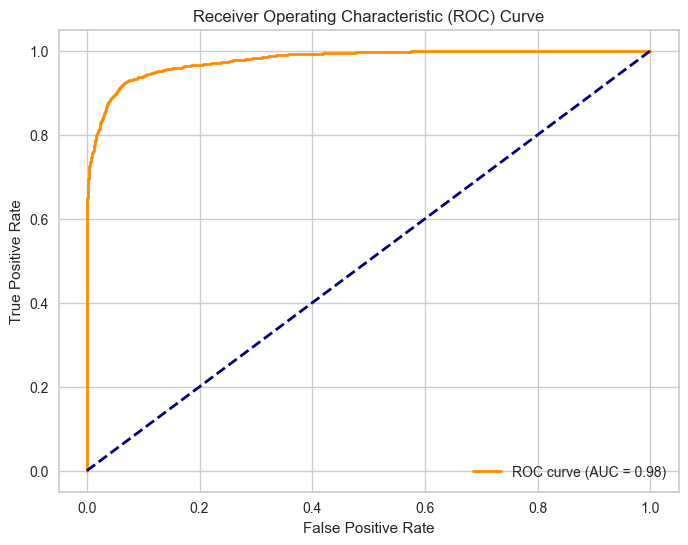

In [ ]:
# 혼동행렬 및 roc_auc 커브 시각화

def get_metrics(X_test, y_test, predictor):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import roc_curve, auc
    
    y_pred = predictor.predict(X_test)  # 실제 값과 예측 값
    cm = confusion_matrix(y_test, y_pred) # 혼동행렬 계산

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Not Churned", "Churned"],
                yticklabels=["Not Churned", "Churned"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    # 예측 확률 계산 (양성 클래스에 대한 확률)
    y_prob = predictor.predict_proba(X_test).iloc[:, 1]

    # ROC 커브 계산
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # ROC 커브 시각화
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 대각선 기준선
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return y_pred, y_prob

y_pred, y_prob = get_metrics(X_test, y_test, predictor)

#### 고객 군집 <a class="anchor" id="section_1_8"></a>

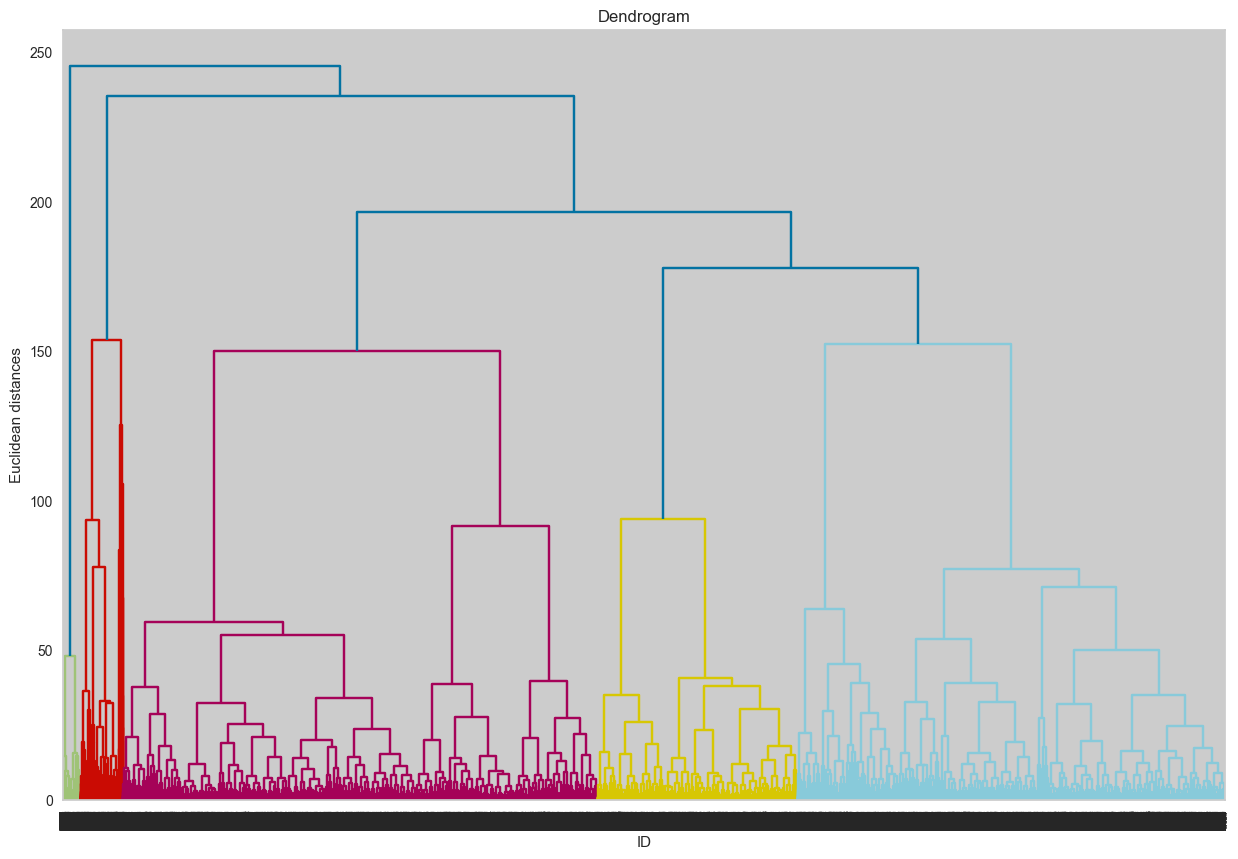

In [ ]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca.iloc[:, col])

plt.figure(figsize=(15,10))
plt.title('Dendrogram')
plt.xlabel('ID')
plt.ylabel('Euclidean distances')
dgram = dendrogram(linkage(X_scaled, method = 'ward'))
plt.show()

In [92]:
kmeans = KMeans(n_clusters=6, random_state=42).fit(X_scaled)
df_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X_scaled.columns)

,PCA_Cluster_9,PCA_Cluster_2,Target_Men,conversion_rate,join_period,shipment_fee
0,-0.030162,-0.055863,-0.075518,-0.106366,1.241359,-0.151661
1,0.006111,0.157322,0.013832,-0.231304,-0.080379,1.952158
2,5.478074,4.185697,-0.003015,-0.558850,-0.115664,1.113395
3,-0.102928,-0.072636,-0.811088,-0.086712,-0.616993,-0.232355
4,-0.358965,-0.550115,-0.010391,6.868073,0.583171,-0.668779
5,-0.138401,-0.115038,1.034998,-0.082093,-0.512453,-0.250096


In [ ]:
import plotly.graph_objects as go

def plot_radar_from_centroid(df_centroids):
  fig = go.Figure()
  categories = df_centroids.columns
  for row in df_centroids.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row[1].tolist(),
        theta=categories,
        fill='toself',
        name='cluster {}'.format(row[0])
    ))

  fig.update_layout(
      autosize=False,
      width=1000,
      height=800,
  )
  fig.show()
  
plot_radar_from_centroid(df_centroids)

In [95]:
#Kmeans Centroid를 실제값으로 풀어서 클러스터별 특성 살펴보기
df_cluster_res = pd.DataFrame(scaler.inverse_transform(X_scaled), columns = X_scaled.columns)
df_cluster_res['cluster'] = kmeans.labels_
df_cluster_res.head()

,PCA_Cluster_9,PCA_Cluster_2,Target_Men,conversion_rate,join_period,shipment_fee,cluster
0,-7.616941,-10.096774,0.333333,7.42,47.0,20000.0,0
1,-10.611312,-10.367779,0.333333,2.84,17.0,20000.0,3
2,-9.613188,-10.849892,0.666667,8.82,13.0,15000.0,5
3,-10.733772,-10.953923,0.000000,7.14,4.0,15000.0,3
4,-9.735648,-8.144216,0.000000,4.76,34.0,10000.0,3


In [ ]:
probabilities.columns = ['churn_no_proba', 'churn_yes_proba']
data = pd.concat([probabilities, final[['customer_id', 'is_churned']]], axis = 1)
data = pd.concat([data, df_cluster_res], axis = 1)
data

,churn_no_proba,churn_yes_proba,customer_id,is_churned,PCA_Cluster_9,PCA_Cluster_2,Target_Men,conversion_rate,join_period,shipment_fee,cluster
0,0.963403,0.036597,3,0,-7.616941,-10.096774,0.333333,7.42,47.0,20000.0,0
1,0.991589,0.008411,8,0,-10.611312,-10.367779,0.333333,2.84,17.0,20000.0,3
2,0.943068,0.056932,9,0,-9.613188,-10.849892,0.666667,8.82,13.0,15000.0,5
3,0.360105,0.639895,11,1,-10.733772,-10.953923,0.000000,7.14,4.0,15000.0,3
4,0.053551,0.946449,15,1,-9.735648,-8.144216,0.000000,4.76,34.0,10000.0,3
...,...,...,...,...,...,...,...,...,...,...,...
38168,0.940906,0.059094,99989,0,-4.500110,-10.585665,0.800000,21.74,15.0,30000.0,5
38169,0.433704,0.566296,99991,1,-10.672542,-9.652904,0.500000,10.53,17.0,25000.0,3
38170,0.957214,0.042786,99992,0,-8.615064,-9.775000,0.666667,8.55,25.0,20000.0,5
38171,0.997640,0.002360,99995,0,-8.553834,23.966611,0.250000,4.99,23.0,35000.0,3


In [ ]:
data.to_csv('cluster.csv', sep = ',', encoding = 'utf-8', index = True)
merged_data.to_csv('merged_data.csv', sep = ',', encoding = 'utf-8', index = False)

#### 장바구니 분석 <a class="anchor" id="section_1_9"></a>

In [ ]:
col = ['booking_id', 'customer_id', 'transaction_date', 'transaction_time', 'subCategory']
apriori_df = merged_df[col]
apriori_df.head(3)

,booking_id,customer_id,transaction_date,transaction_time,subCategory
36,91d7b8a0-f3f5-4a0c-843a-f83a75b415e2,4774,2021-08-31,11:05:02,Topwear
37,91d7b8a0-f3f5-4a0c-843a-f83a75b415e2,4774,2021-08-31,11:05:02,Shoes
38,6a32b1ef-142a-41f8-8046-f9b74676233d,4774,2021-10-17,11:45:13,Topwear


In [ ]:
# period_day 컬럼 생성
def get_period(time):
    if time.hour < 6:
        return 'Night'  # 밤 (00:00 ~ 05:59)
    elif time.hour < 12:
        return 'Morning'  # 아침 (06:00 ~ 11:59)
    elif time.hour < 18:
        return 'Afternoon'  # 오후 (12:00 ~ 17:59)
    else:
        return 'Evening'  # 저녁 (18:00 ~ 23:59)


apriori_df['period_day'] = apriori_df['transaction_time'].apply(get_period)

# weekday_weekend 컬럼 생성
def get_weekday_weekend(date):
    if date.weekday() < 5:  # 월요일(0) ~ 금요일(4)
        return 'Weekday'
    else:  # 토요일(5), 일요일(6)
        return 'Weekend'

apriori_df['weekday_weekend'] = apriori_df['transaction_date'].apply(get_weekday_weekend)
apriori_df


,booking_id,customer_id,transaction_date,transaction_time,subCategory,period_day,weekday_weekend
36,91d7b8a0-f3f5-4a0c-843a-f83a75b415e2,4774,2021-08-31,11:05:02,Topwear,Morning,Weekday
37,91d7b8a0-f3f5-4a0c-843a-f83a75b415e2,4774,2021-08-31,11:05:02,Shoes,Morning,Weekday
38,6a32b1ef-142a-41f8-8046-f9b74676233d,4774,2021-10-17,11:45:13,Topwear,Morning,Weekend
39,e319fd63-6af2-4103-bf76-4b84658ac92f,4774,2021-12-03,11:55:49,Shoes,Morning,Weekday
40,0d1342a0-bac8-4837-bea6-4196033422a5,4774,2022-01-19,11:25:46,Topwear,Morning,Weekday
...,...,...,...,...,...,...,...
1254574,ca733563-1455-482d-bae0-e47337304019,99675,2022-06-08,02:44:08,Bottomwear,Night,Weekday
1254575,1849df71-943e-431d-8731-35b75670203a,99675,2022-07-07,09:48:29,Jewellery,Morning,Weekday
1254580,66f02fa4-c62e-497a-8b6e-be239009b50a,25121,2021-09-21,22:10:05,Topwear,Evening,Weekday
1254581,ccde6b83-ee42-4cce-b2cd-976574886eac,34829,2021-12-09,07:35:18,Topwear,Morning,Weekday


In [ ]:
df = apriori_df.copy()

In [ ]:
# 날짜 결합
df['transaction_date'] = df['transaction_date'].astype(str)
df['transaction_time'] = df['transaction_time'].astype(str)
df['transaction_datetime'] = pd.to_datetime(df['transaction_date'] + ' ' + df['transaction_time'])

# 월 추출
df['month'] = df['transaction_datetime'].dt.month
df['month'] = df['month'].replace((1,2,3,4,5,6,7,8,9,10,11,12), 
                                          ('January','February','March','April','May','June','July','August',
                                          'September','October','November','December'))

# 시간 추출
df['hour'] = df['transaction_datetime'].dt.hour
# 텍스트 변경
hour_in_num = (0, 1, 2, 3, 4, 5, 6, 7, 8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23)
hour_in_obj = ('00-01', '01-02', '02-03', '03-04', '04-05', '05-06', '06-07', '07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15',
               '15-16','16-17','17-18','18-19','19-20','20-21','21-22','22-23','23-24')
df['hour'] = df['hour'].replace(hour_in_num, hour_in_obj)

# 요일 추출
df['weekday'] = df['transaction_datetime'].dt.weekday
df['weekday'] = df['weekday'].replace((0,1,2,3,4,5,6), 
                                          ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'))

# dropping date_time column
df.drop(['transaction_datetime'], axis = 1, inplace = True)
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['transaction_time'] = pd.to_datetime(df['transaction_time']).dt.time
df.dropna(inplace=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy

In [ ]:
# cleaning the item column
df['subCategory'] = df['subCategory'].str.strip()
df['subCategory'] = df['subCategory'].str.lower()


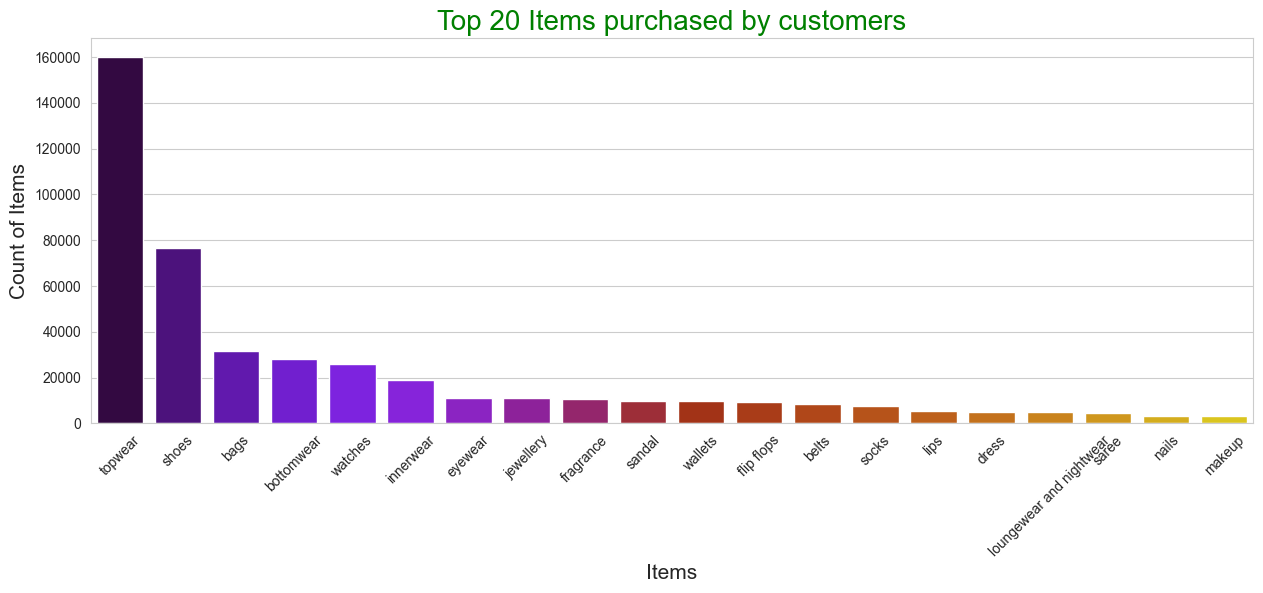

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x = df.subCategory.value_counts().head(20).index, y = df.subCategory.value_counts().head(20).values, palette = 'gnuplot')
plt.xlabel('Items', size = 15)
plt.xticks(rotation=45)
plt.ylabel('Count of Items', size = 15)
plt.title('Top 20 Items purchased by customers', color = 'green', size = 20)
plt.show()

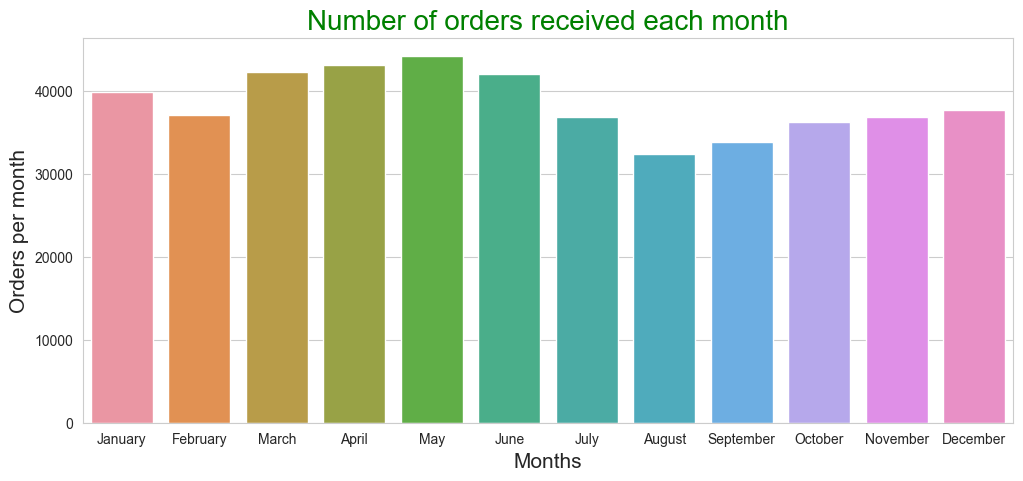

In [ ]:
monthTran = df.groupby('month')['booking_id'].count().reset_index()
monthTran.loc[:,"monthorder"] = [4,8,12,2,1,7,6,3,5,11,10,9]
monthTran.sort_values("monthorder",inplace=True)

plt.figure(figsize=(12,5))
sns.barplot(data = monthTran, x = "month", y = "booking_id")
plt.xlabel('Months', size = 15)
plt.ylabel('Orders per month', size = 15)
plt.title('Number of orders received each month', color = 'green', size = 20)
plt.show()

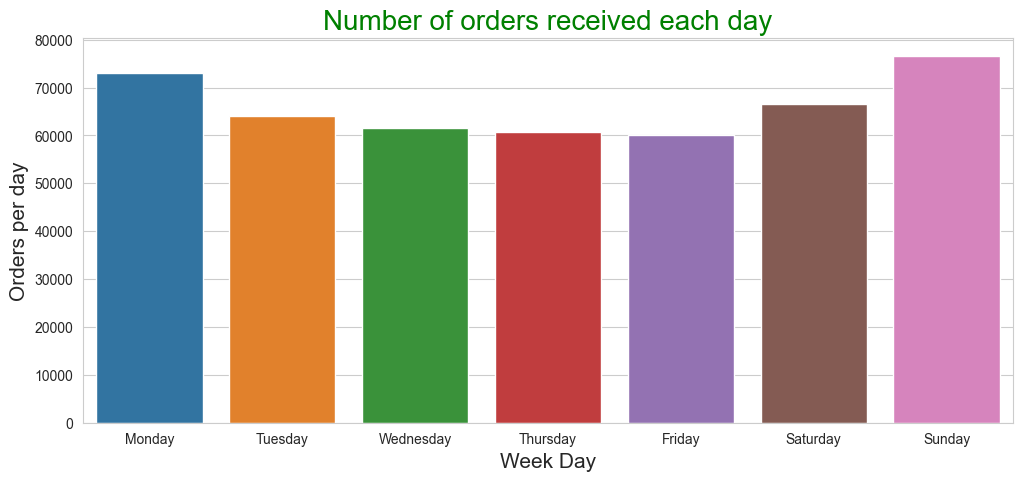

In [ ]:
weekTran = df.groupby('weekday')['booking_id'].count().reset_index()
weekTran.loc[:,"weekorder"] = [4,0,5,6,3,1,2]
weekTran.sort_values("weekorder",inplace=True)

plt.figure(figsize=(12,5))
sns.barplot(data = weekTran, x = "weekday", y = "booking_id")
plt.xlabel('Week Day', size = 15)
plt.ylabel('Orders per day', size = 15)
plt.title('Number of orders received each day', color = 'green', size = 20)
plt.show()


plt.show()

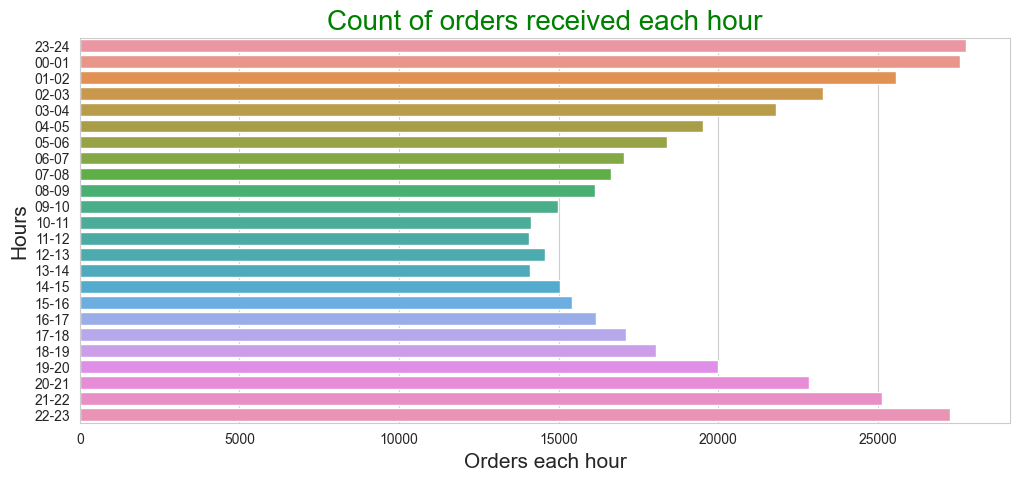

In [ ]:
hourTran = df.groupby('hour')['booking_id'].count().reset_index()
hourTran.loc[:,"hourorder"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15,16,17,18,19,20,21,22,23, 0]
hourTran.sort_values("hourorder",inplace=True)

plt.figure(figsize=(12,5))
sns.barplot(data = hourTran, x = "booking_id", y = "hour")
plt.ylabel('Hours', size = 15)
plt.xlabel('Orders each hour', size = 15)
plt.title('Count of orders received each hour', color = 'green', size = 20)
plt.show()

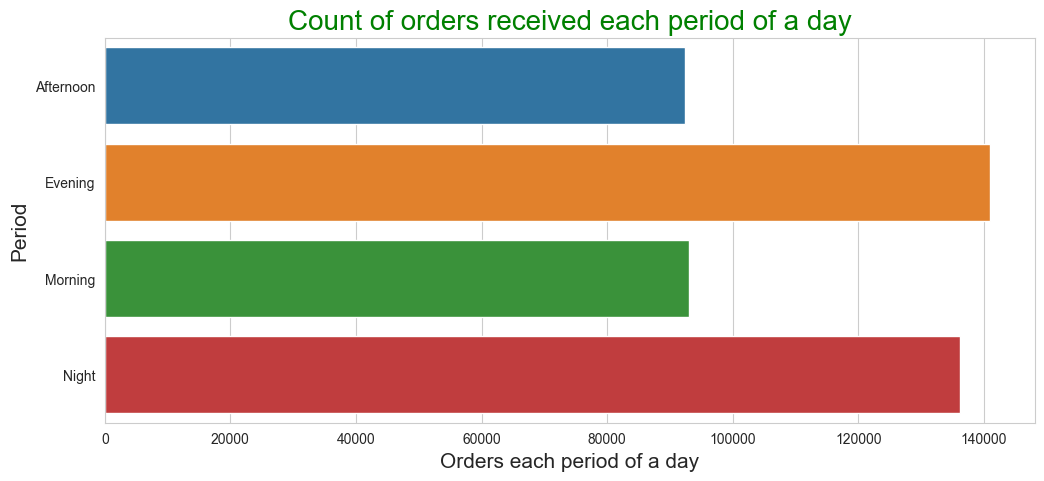

In [ ]:
dayTran = df.groupby('period_day')['booking_id'].count().reset_index()
# dayTran.loc[:,"hourorder"] = [1,10,11,12,13,14,15,16,17,18,19,20,21,22,23,7,8,9]
# dayTran.sort_values("hourorder",inplace=True)

plt.figure(figsize=(12,5))
sns.barplot(data = dayTran, x = "booking_id", y = "period_day")
plt.ylabel('Period', size = 15)
plt.xlabel('Orders each period of a day', size = 15)
plt.title('Count of orders received each period of a day', color = 'green', size = 20)
plt.show()

In [ ]:
dates = df.groupby('transaction_date')['booking_id'].count().reset_index()
dates = dates[dates['booking_id']>=200].sort_values('transaction_date').reset_index(drop = True)

dates = pd.merge(dates, df[['transaction_date','weekday']], on = 'transaction_date', how = 'inner')
dates.drop_duplicates(inplace =True)
dates

,transaction_date,booking_id,weekday
0,2021-08-02,1218,Monday
1218,2021-08-03,1010,Tuesday
2228,2021-08-04,933,Wednesday
3161,2021-08-05,942,Thursday
4103,2021-08-06,944,Friday
...,...,...,...
457534,2022-07-27,990,Wednesday
458524,2022-07-28,843,Thursday
459367,2022-07-29,715,Friday
460082,2022-07-30,883,Saturday


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy

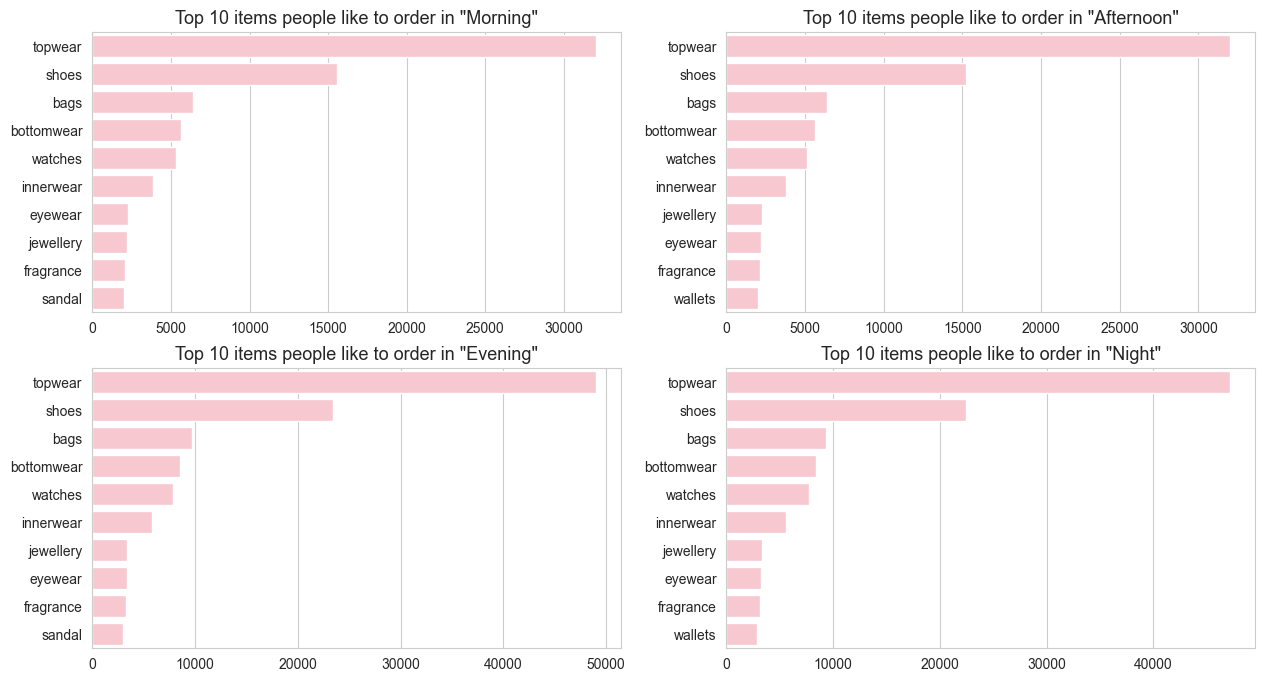

In [ ]:
data = df.groupby(['period_day','subCategory'])['booking_id'].count().reset_index().sort_values(['period_day','booking_id'],ascending=False)
day = ['Morning','Afternoon','Evening','Night']

plt.figure(figsize=(15,8))
for i,j in enumerate(day):
    plt.subplot(2,2,i+1)
    df1 = data[data.period_day==j].head(10)
    sns.barplot(data=df1, y=df1.subCategory, x=df1.booking_id, color='pink')
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Top 10 items people like to order in "{}"'.format(j), size=13)

plt.show()

In [ ]:
from mlxtend.frequent_patterns import association_rules, apriori

In [ ]:
# test = df.copy()
# # 1. productDisplayName의 value_counts 계산
# value_counts = test['subCategory'].value_counts()

# # 2. Q1 (25th percentile), Q3 (75th percentile) 및 IQR 계산
# Q1 = value_counts.quantile(0.25)
# Q3 = value_counts.quantile(0.75)
# IQR = Q3 - Q1

# # 3. 하한값(lower bound) 계산
# lower_bound = Q3 + 1.5 * IQR

# # 4. 하한값 이상인 항목만 필터링
# filtered_counts = value_counts[value_counts >= lower_bound]

# # 5. 원본 데이터프레임에서 필터링된 항목만 유지
# products_to_keep = filtered_counts.index.tolist()
# filtered_df = test[test['subCategory'].isin(products_to_keep)]
# filtered_df

In [ ]:
# df = filtered_df.copy()

In [ ]:
df = df[df['month'] == 'August']

In [ ]:
transactions_str = df.groupby(['customer_id', 'subCategory'])['subCategory'].count().reset_index(name ='Count')
transactions_str

,customer_id,subCategory,Count
0,3,watches,1
1,21,shoes,1
2,24,flip flops,1
3,24,topwear,1
4,28,bags,1
...,...,...,...
26557,99987,shoes,1
26558,99988,shoes,1
26559,99989,shoes,1
26560,99991,topwear,1


In [ ]:
def bar_plot(df,col):

    fig = px.bar(df,
        x = df[col].value_counts().keys(), 
        y = df[col].value_counts().values,
        color= df[col].value_counts().keys()
    )
    fig.update_layout(
    xaxis_title= col,
    yaxis_title="Count",
    legend_title=col,
    font_family="Courier New",
    font_color="blue",
    title_font_family="Times New Roman",
    title_font_color="red",
    legend_title_font_color="green"
)
    
    fig.show()
    
    
bar_plot(df,'subCategory')

In [ ]:
fig = px.treemap(transactions_str, path=['subCategory'], values='Count')
fig.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



In [ ]:
# making a mxn matrice where m=transaction and n=items and each row represents whether the item was in the transaction or not
my_basket = transactions_str.pivot_table(index='customer_id', columns='subCategory', values='Count', aggfunc='sum').fillna(0)
my_basket.head()

subCategory,accessories,apparel set,bags,bath and body,beauty accessories,belts,bottomwear,cufflinks,dress,eyes,eyewear,flip flops,fragrance,free gifts,gloves,hair,headwear,innerwear,jewellery,lips,loungewear and nightwear,makeup,mufflers,nails,perfumes,sandal,saree,scarves,shoe accessories,shoes,skin,skin care,socks,sports equipment,stoles,ties,topwear,umbrellas,wallets,watches,water bottle,wristbands
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
47,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# making a function which returns 0 or 1
# 0 means item was not in that transaction, 1 means item present in that transaction

def encode(x):
    if x<=0:
        return 0
    if x>=1:
        return 1

# applying the function to the dataset

my_basket_sets = my_basket.applymap(encode)
my_basket_sets.head()

subCategory,accessories,apparel set,bags,bath and body,beauty accessories,belts,bottomwear,cufflinks,dress,eyes,eyewear,flip flops,fragrance,free gifts,gloves,hair,headwear,innerwear,jewellery,lips,loungewear and nightwear,makeup,mufflers,nails,perfumes,sandal,saree,scarves,shoe accessories,shoes,skin,skin care,socks,sports equipment,stoles,ties,topwear,umbrellas,wallets,watches,water bottle,wristbands
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
28,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
47,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# using the 'apriori algorithm' with min_support=0.01 (1% of 9465)
# It means the item should be present in atleast 94 transaction out of 9465 transactions only when we considered that item in
# frequent itemset
# 기존 데이터프레임을 Boolean 타입으로 변환
my_basket_sets = my_basket_sets.astype(bool)
# NaN 값을 False로 대체
my_basket_sets = my_basket_sets.fillna(False)

frequent_items = apriori(my_basket_sets, min_support = 0.01, use_colnames = True)
frequent_items['length'] = frequent_items['itemsets'].apply(lambda x: len(x))
frequent_items.head()

,support,itemsets,length
0,0.129263,(bags),1
1,0.037945,(belts),1
2,0.115357,(bottomwear),1
3,0.023111,(dress),1
4,0.050262,(eyewear),1


In [ ]:
# now making the rules from frequent itemset generated above

rules = association_rules(frequent_items, metric='lift', min_threshold=1, num_itemsets=len(my_basket_sets))
rules.sort_values('confidence', ascending = False, inplace = True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
171,"(bags, bottomwear, shoes)",(topwear),0.011787,0.492881,0.010662,0.904494,1.835116,1.0,0.004852,5.309831,0.460503,0.021582,0.811670,0.463063
186,"(bags, watches, shoes)",(topwear),0.011721,0.492881,0.010463,0.892655,1.811096,1.0,0.004686,4.724211,0.453160,0.021174,0.788324,0.456942
111,"(bottomwear, watches)",(topwear),0.015959,0.492881,0.012781,0.800830,1.624793,1.0,0.004915,2.546159,0.390773,0.025764,0.607251,0.413380
98,"(innerwear, bottomwear)",(topwear),0.012979,0.492881,0.010330,0.795918,1.614828,1.0,0.003933,2.484882,0.385746,0.020847,0.597566,0.408439
74,"(bags, innerwear)",(topwear),0.015363,0.492881,0.012052,0.784483,1.591626,1.0,0.004480,2.353031,0.377512,0.024289,0.575016,0.404468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,(topwear),(saree),0.492881,0.020595,0.010926,0.022168,1.076419,1.0,0.000776,1.001609,0.139994,0.021742,0.001607,0.276358
182,(topwear),"(bags, bottomwear, shoes)",0.492881,0.011787,0.010662,0.021631,1.835116,1.0,0.004852,1.010061,0.897374,0.021582,0.009961,0.463063
144,(topwear),"(innerwear, watches)",0.492881,0.013906,0.010595,0.021497,1.545818,1.0,0.003741,1.007757,0.696274,0.021353,0.007697,0.391701
195,(topwear),"(bags, watches, shoes)",0.492881,0.011721,0.010463,0.021228,1.811096,1.0,0.004686,1.009713,0.883123,0.021174,0.009620,0.456942


In [ ]:
def frozenset_str(rules):
    import re
    
    # 괄호 안의 텍스트 추출
    rules['antecedents'] = rules['antecedents'].astype(str)
    rules['antecedents'] = rules['antecedents'].str.strip()
    rules['antecedents'] = rules['antecedents'].str.extract(r'\((.*?)\)')
    
    rules['consequents'] = rules['consequents'].astype(str)
    rules['consequents'] = rules['consequents'].str.strip()
    rules['consequents'] = rules['consequents'].str.extract(r'\((.*?)\)')
    
    return rules

rules = frozenset_str(rules)
rules



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
171,"{'bags', 'bottomwear', 'shoes'}",{'topwear'},0.011787,0.492881,0.010662,0.904494,1.835116,1.0,0.004852,5.309831,0.460503,0.021582,0.811670,0.463063
186,"{'bags', 'watches', 'shoes'}",{'topwear'},0.011721,0.492881,0.010463,0.892655,1.811096,1.0,0.004686,4.724211,0.453160,0.021174,0.788324,0.456942
111,"{'bottomwear', 'watches'}",{'topwear'},0.015959,0.492881,0.012781,0.800830,1.624793,1.0,0.004915,2.546159,0.390773,0.025764,0.607251,0.413380
98,"{'innerwear', 'bottomwear'}",{'topwear'},0.012979,0.492881,0.010330,0.795918,1.614828,1.0,0.003933,2.484882,0.385746,0.020847,0.597566,0.408439
74,"{'bags', 'innerwear'}",{'topwear'},0.015363,0.492881,0.012052,0.784483,1.591626,1.0,0.004480,2.353031,0.377512,0.024289,0.575016,0.404468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,{'topwear'},{'saree'},0.492881,0.020595,0.010926,0.022168,1.076419,1.0,0.000776,1.001609,0.139994,0.021742,0.001607,0.276358
182,{'topwear'},"{'bags', 'bottomwear', 'shoes'}",0.492881,0.011787,0.010662,0.021631,1.835116,1.0,0.004852,1.010061,0.897374,0.021582,0.009961,0.463063
144,{'topwear'},"{'innerwear', 'watches'}",0.492881,0.013906,0.010595,0.021497,1.545818,1.0,0.003741,1.007757,0.696274,0.021353,0.007697,0.391701
195,{'topwear'},"{'bags', 'watches', 'shoes'}",0.492881,0.011721,0.010463,0.021228,1.811096,1.0,0.004686,1.009713,0.883123,0.021174,0.009620,0.456942


In [ ]:
rules.to_csv('basket.csv', sep = ',', encoding='utf-8', index=False)

In [ ]:
fig=px.scatter(rules['support'], rules['confidence'])
fig.update_layout(
    xaxis_title="support",
    yaxis_title="confidence",
   
    font_family="Courier New",
    font_color="blue",
    title_font_family="Times New Roman",
    title_font_color="red",
    title=('Support vs Confidence')
    
)

fig.show()

In [ ]:
fig=px.scatter(rules['support'], rules['lift'])
fig.update_layout(
    xaxis_title="support",
    yaxis_title="lift",
   
    font_family="Courier New",
    font_color="blue",
    title_font_family="Times New Roman",
    title_font_color="red",
    title=('Support vs Confidence')
    
)

fig.show()

Text(0.5, 1.0, 'lift vs Confidence')

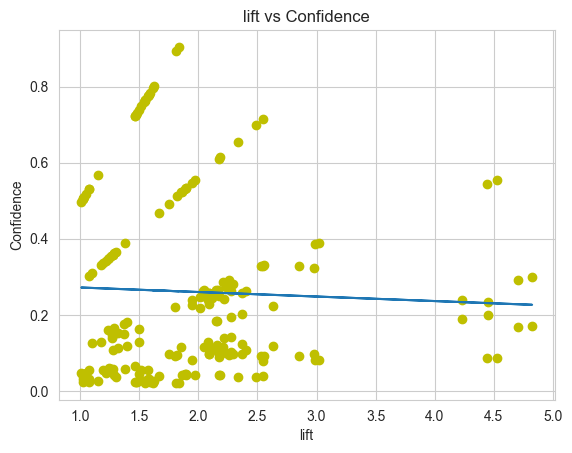

In [ ]:
fit = np.polyfit(rules['lift'], rules['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.plot(rules['lift'], rules['confidence'], 'yo', rules['lift'], 
fit_fn(rules['lift']))
plt.xlabel('lift')
plt.ylabel('Confidence')
plt.title('lift vs Confidence')